In [1]:
import sys
sys.path.insert(0, "../")

import logging
import random
from copy import deepcopy

import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from openTSNE import TSNE
from scipy.signal import savgol_filter
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from src.dataloader import *
from triage.triage import Triage
from src.utils import *

In [2]:
df, _, _ = load_seer_cutract_dataset(name="seer", seed=42)

cols = df.columns
long_tail = False
imbalance = False

In [3]:
def evaluate_methods(
    X_prop_train,
    y_prop_train,
    X_cal,
    y_cal,
    X_test,
    y_test,
    seed,
    nest,
    groups_id,
    long_tail=False,
    imbalance=False,
):
    from sklearn.metrics import mean_absolute_error as reg_metric
    from sklearn.metrics import mean_squared_error as reg_metric_mse
    from sklearn.linear_model import LinearRegression

    results = {}
    results_mse = {}

    extra_eval = False

    if imbalance is True or long_tail is True:
        results_mse_above = {}
        results_mse_below = {}
        extra_eval = True

        if imbalance is True:
            for i in range(len(cols)):
                if cols[i] == "age":
                    idx = i

                above_ids = np.where(X_test[:, idx] >= 65)[0]
                below_ids = np.where(X_test[:, idx] < 65)[0]

        elif long_tail is True:
            y_test > 0.75
            above_ids = np.where(y_test > 0.75)[0]
            below_ids = np.where(y_test < 0.75)[0]

    ######
    print("TRIAGE WE...")
    myids = groups_id["we_group"]
    keep = len(myids)
    print(f"{cal_size} - keep is {keep}")

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["TRIAGE_WE"] = reg_metric(y_test, y_pred)
    results_mse["TRIAGE_WE"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["TRIAGE_WE"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["TRIAGE_WE"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ######
    print("TRIAGE OE ...")
    myids = groups_id["oe_group"]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["TRIAGE_OE"] = reg_metric(y_test, y_pred)
    results_mse["TRIAGE_OE"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["TRIAGE_OE"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["TRIAGE_OE"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ######
    print("TRIAGE UE...")
    myids = groups_id["ue_group"]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["TRIAGE_UE"] = reg_metric(y_test, y_pred)
    results_mse["TRIAGE_UE"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["TRIAGE_UE"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["TRIAGE_UE"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ######
    print("TRIAGE Combined...")
    myids = np.hstack(
        (np.array(groups_id["ue_group"]), np.array(groups_id["oe_group"]))
    )

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["TRIAGE_Combined"] = reg_metric(y_test, y_pred)
    results_mse["TRIAGE_Combined"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["TRIAGE_Combined"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["TRIAGE_Combined"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    #######
    print("CPS CONFIDENCE...")
    confidence = groups_id["confidence"]
    myids = np.where((confidence < 0.8) & (confidence > 0.2))[0]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["Confidence"] = reg_metric(y_test, y_pred)
    results_mse["Confidence"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["Confidence"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["Confidence"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    #####
    print("RESIDUALS DIRECT...")
    errors_array = groups_id["errors_array"]
    myids = np.argsort(np.abs(np.mean(errors_array, axis=-1)))[0:keep]

    myids = np.argsort(np.abs(errors_array)[:, -1])[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["Residuals_direct"] = reg_metric(y_test, y_pred)
    results_mse["Residuals_direct"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["Residuals_direct"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["Residuals_direct"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    #####
    print("INTERVALS DIRECT...")
    interval_array = groups_id["interval_array"]
    # myids = np.argsort(np.abs(np.mean(interval_array, axis=-1)))[0:keep]
    myids = np.argsort(np.abs(interval_array)[:, -1])[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["Intervals_direct"] = reg_metric(y_test, y_pred)
    results_mse["Intervals_direct"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["Intervals_direct"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["Intervals_direct"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ####
    print("Actual eval fit...")
    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_cal, y_cal)

    y_pred = learner_prop.predict(X_test)

    results["True_eval_fit"] = reg_metric(y_test, y_pred)
    results_mse["True_eval_fit"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["True_eval_fit"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["True_eval_fit"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ####
    print("MIX fit...")
    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(np.vstack((X_prop_train, X_cal)),
                     np.hstack((y_prop_train, y_cal)))

    y_pred = learner_prop.predict(X_test)

    results["True_MIX"] = reg_metric(y_test, y_pred)
    results_mse["True_MIX"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["True_MIX"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["True_MIX"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ####
    print("Plain...")
    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train, y_prop_train)

    y_pred = learner_prop.predict(X_test)

    results["True_plain"] = reg_metric(y_test, y_pred)
    results_mse["True_plain"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["True_plain"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["True_plain"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ######

    print("RESIDUALS FIT CAL...")
    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_cal, y_cal)

    y_pred = learner_prop.predict(X_prop_train)

    residuals = y_prop_train - y_pred

    myids = np.argsort(np.abs(residuals))[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["Residuals_fit_cal"] = reg_metric(y_test, y_pred)
    results_mse["Residuals_fit_cal"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["Residuals_fit_cal"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["Residuals_fit_cal"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ######
    print("NGBOOST...")
    from ngboost import NGBRegressor
    from ngboost.distns import Normal

    base_learner = LinearRegression()

    learner_prop = NGBRegressor(Dist=Normal, Base=base_learner)
    learner_prop.fit(X_cal, y_cal)

    y_dists = learner_prop.pred_dist(X_prop_train)
    uncerts = y_dists[0:].params["scale"]

    myids = np.argsort(uncerts)[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["NGBOOST"] = reg_metric(y_test, y_pred)
    results_mse["NGBOOST"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["NGBOOST"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["NGBOOST"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    print("Bayes ridge alea...")
    from sklearn.linear_model import BayesianRidge

    class ModifiedBayesianRidge(BayesianRidge):
        def predict(self, X):
            y_mean = self._decision_function(X)
            aleatoric = 1.0 / self.alpha_
            epistemic = (np.dot(X, self.sigma_) * X).sum(axis=1)
            return y_mean, aleatoric, epistemic

    learner_prop = ModifiedBayesianRidge()

    learner_prop.fit(X_cal, y_cal)

    y_dists, aleatoric, epistemic = learner_prop.predict(X_prop_train)

    myids = np.argsort(aleatoric)[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["Bayesian_ridge_aleatoric"] = reg_metric(y_test, y_pred)
    results_mse["Bayesian_ridge_aleatoric"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["Bayesian_ridge_aleatoric"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["Bayesian_ridge_aleatoric"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ########
    print("Bayes ridge...")
    from sklearn.linear_model import BayesianRidge

    learner_prop = BayesianRidge()

    learner_prop.fit(X_cal, y_cal)

    y_dists, uncerts = learner_prop.predict(X_prop_train, return_std=True)

    myids = np.argsort(uncerts)[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["Bayesian_ridge"] = reg_metric(y_test, y_pred)
    results_mse["Bayesian_ridge"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["Bayesian_ridge"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids]
        )
        results_mse_below["Bayesian_ridge"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids]
        )

    ########

    # import torch

    # from uq360.algorithms.variational_bayesian_neural_networks.bnn import BnnRegression

    # config = {
    #               "ip_dim":X_prop_train.shape[1],
    #               "op_dim":1,
    #               "num_nodes":8,
    #               "num_layers":5,
    #               "step_size":3e-2,
    #               "num_epochs":20,
    #               "random_state":seed,
    #           }

    # learner_prop = BnnRegression(config = config, prior = 'Gaussian') #, Hshoe, RegHshoe

    # learner_prop.fit(torch.Tensor(X_cal), torch.Tensor(y_cal))

    # y_dists, lower, upper, _, _ = learner_prop.predict(torch.Tensor(X_prop_train))

    # uncerts = upper-lower

    # myids = np.argsort(uncerts)[0:keep]

    # print(f'Fitting on cal size = {X_cal.shape}')
    # print(f'BNN refit = {X_prop_train[myids,:].shape}, {len(uncerts)}')

    # learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    # learner_prop.fit(X_prop_train[myids,:], y_prop_train[myids])

    # y_pred = learner_prop.predict(X_test)

    # results['BNN'] = reg_metric(y_test, y_pred)
    # results_mse['BNN'] = reg_metric_mse(y_test, y_pred)

    # if extra_eval==True:
    #     results_mse_above['BNN'] = reg_metric_mse(y_test[above_ids], y_pred[above_ids])
    #     results_mse_below['BNN'] = reg_metric_mse(y_test[below_ids], y_pred[below_ids])

    ########

    from sklearn.gaussian_process import GaussianProcessRegressor

    gpr = GaussianProcessRegressor(random_state=seed)
    gpr.fit(X_cal, y_cal)

    y_dists, uncerts = gpr.predict(X_prop_train, return_std=True)

    myids = np.argsort(uncerts)[0:keep]

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids, :], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results["GP"] = reg_metric(y_test, y_pred)
    results_mse["GP"] = reg_metric_mse(y_test, y_pred)

    if extra_eval is True:
        results_mse_above["GP"] = reg_metric_mse(
            y_test[above_ids], y_pred[above_ids])
        results_mse_below["GP"] = reg_metric_mse(
            y_test[below_ids], y_pred[below_ids])

    if extra_eval is True:
        return results, results_mse, results_mse_above, results_mse_below

    else:
        return results, results_mse

In [4]:
full_results = {}
full_results_mse = {}
full_results_mse_above = {}
full_results_mse_below = {}
full_pvals = {}
full_errors = {}
full_crps = {}
full_cpds = {}
full_intervals = {}
full_preds = {}
full_upper = {}
full_lower = {}


cal_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


n_runs = 1

for cal_size in tqdm(cal_list):
    print("--------------------------------")
    print(f"Running cal size = {cal_size}")
    print("--------------------------------")
    final_results = []
    final_results_mse = []
    final_results_mse_above = []
    final_results_mse_below = []
    for i in range(n_runs):

        seed = i * 10
        random.seed(seed)
        seed_everything(seed)

        X_prop_train, y_prop_train, _ = load_seer_cutract_dataset(
            name="seer", seed=seed
        )

        min_y = y_prop_train.min()
        max_y = y_prop_train.max()

        y_prop_train = np.array(
            [
                (y_prop_train[i] - min_y) / (max_y - min_y)
                for i in range(len(y_prop_train))
            ]
        )
        y_prop_train = pd.Series(y_prop_train)

        X_test_all, y_test_all, _ = load_seer_cutract_dataset(
            name="cutract", seed=seed)

        y_test_all = np.array(
            [(y_test_all[i] - min_y) / (max_y - min_y)
             for i in range(len(y_test_all))]
        )
        y_test_all = pd.Series(y_test_all)

        test_ids = random.sample(
            list(range(len(y_test_all))), int(0.5 * len(y_test_all))
        )

        X_test, y_test = X_test_all.iloc[test_ids,
                                         :], y_test_all.iloc[test_ids]

        remaining_eval_ids = np.setdiff1d(range(len(y_test_all)), test_ids)

        _, X_cal, _, y_cal = train_test_split(
            X_test_all.iloc[remaining_eval_ids, :],
            y_test_all.iloc[remaining_eval_ids],
            test_size=cal_size,
            random_state=seed,
        )

        X_prop_train, X_cal, X_test = (
            np.array(X_prop_train),
            np.array(X_cal),
            np.array(X_test),
        )
        y_prop_train, y_cal, y_test = (
            np.array(y_prop_train),
            np.array(y_cal),
            np.array(y_test),
        )

        prop = 0.1
        num_ids = int(prop * len(y_prop_train))
        last_ids = range(len(y_prop_train))
        y_prop_train_corrupt = deepcopy(y_prop_train)
        corruptids = random.sample(list(last_ids), num_ids)
        for myid in corruptids:
            corruption = (np.random.choice(5, 1)[0] / 2) + 1
            y_prop_train_corrupt[myid] = y_prop_train_corrupt[myid] * corruption

        nest = 10
        learner = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
        learner.fit(X_prop_train, y_prop_train)

        y_eval = y_prop_train
        X_eval = X_prop_train

        triage = Triage(
            X_eval=X_eval,
            y_eval=y_eval,
            X_cal=X_cal,
            y_cal=y_cal,
            nest=nest,
            learner=learner,
        )
        groups_ids, raw_metrics = triage.run(
            compute_cpd=True, compute_crps=True)

        triage_array = raw_metrics["score_metric"]
        errors_array = raw_metrics["errors_array"]
        interval_array = raw_metrics["interval_array"]
        crps_array = raw_metrics["crps_array"]
        cpds_array = raw_metrics["cpds_array"]
        preds_array = raw_metrics["preds_array"]
        upper_array = raw_metrics["upper_array"]
        lower_array = raw_metrics["lower_array"]

        metric = triage_array

        percentile_thresh = 75
        thresh = 0.33
        conf_thresh_low = thresh
        conf_thresh_high = 1 - thresh
        conf_thresh = 0.5

        uncert = np.mean(metric * (1 - metric), axis=-1)
        confidence = np.mean(metric, axis=-1)

        # Get groups and mainly well-estimated groups
        oe_group = np.where(
            (confidence <= conf_thresh_low)
            & (uncert <= np.percentile(uncert, percentile_thresh))
        )[0]
        ue_group = np.where(
            (confidence >= conf_thresh_high)
            & (uncert <= np.percentile(uncert, percentile_thresh))
        )[0]

        combined_group = np.concatenate((oe_group, ue_group))

        we_group = []
        for id in range(len(confidence)):
            if id not in combined_group:
                we_group.append(id)

        we_group = np.array(we_group)

        groups_ids = {
            "ue_group": ue_group,
            "oe_group": oe_group,
            "we_group": we_group,
            "confidence": confidence,
            "uncert": uncert,
            "errors_array": errors_array,
            "interval_array": interval_array,
        }

        # groups = []
        # for i in range(len(triage_array)):
        #     if i in easy_train:
        #         groups.append(0)
        #     if i in ambig_train:
        #         groups.append(1)
        #     if i in hard_train:
        #         groups.append(2)

        if long_tail is True or imbalance is True:
            (
                results,
                results_mse,
                results_mse_above,
                results_mse_below,
            ) = evaluate_methods(
                X_prop_train,
                y_prop_train,
                X_cal,
                y_cal,
                X_test,
                y_test,
                seed,
                nest,
                groups_ids,
                long_tail=long_tail,
                imbalance=imbalance,
            )
            final_results_mse_above.append(results_mse_above)
            final_results_mse_below.append(results_mse_below)
        else:
            results, results_mse = evaluate_methods(
                X_prop_train,
                y_prop_train,
                X_cal,
                y_cal,
                X_test,
                y_test,
                seed,
                nest,
                groups_ids,
                long_tail=long_tail,
                imbalance=imbalance,
            )
        print(results)
        final_results.append(results)
        final_results_mse.append(results_mse)

    full_results[cal_size] = final_results
    full_results_mse[cal_size] = final_results_mse
    full_results_mse_above[cal_size] = final_results_mse_above
    full_results_mse_below[cal_size] = final_results_mse_below
    full_pvals[cal_size] = triage_array
    full_errors[cal_size] = errors_array
    full_crps[cal_size] = crps_array
    full_cpds[cal_size] = cpds_array
    full_intervals[cal_size] = interval_array
    full_preds[cal_size] = preds_array
    full_upper[cal_size] = upper_array
    full_lower[cal_size] = lower_array

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.01
--------------------------------
TRIAGE WE...
0.01 - keep is 9653
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-1.2885 val_loss=0.0000 scale=1.0000 norm=0.4142
[iter 100] loss=-1.7729 val_loss=0.0000 scale=1.0000 norm=0.2875
[iter 200] loss=-2.2067 val_loss=0.0000 scale=2.0000 norm=0.4843
[iter 300] loss=-2.6070 val_loss=0.0000 scale=2.0000 norm=0.4573
[iter 400] loss=-3.2655 val_loss=0.0000 scale=4.0000 norm=0.7630


 10%|█         | 1/10 [00:40<06:01, 40.19s/it]

Bayes ridge alea...
Bayes ridge...
{'TRIAGE_WE': 0.13980066519022472, 'TRIAGE_OE': 0.16561378462990436, 'TRIAGE_UE': 0.339142264480533, 'TRIAGE_Combined': 0.2694896341806602, 'Confidence': 0.1445883607009222, 'Residuals_direct': 0.18414321140138062, 'Intervals_direct': 0.1708181303754328, 'True_eval_fit': 0.13650791395247464, 'True_MIX': 0.16649523636363897, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.1352270825447643, 'NGBOOST': 0.1698905521347395, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.16682924732559848, 'GP': 0.14132110394626435}
--------------------------------
Running cal size = 0.02
--------------------------------
TRIAGE WE...
0.02 - keep is 5879
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=0.1338 val_loss=0.0000 scale=1.0000 norm=0.6359
[iter 100] loss=-0.4996 val_loss=0.0000 scale=1.0000 norm=

 20%|██        | 2/10 [01:11<04:38, 34.86s/it]

{'TRIAGE_WE': 0.13742550515464927, 'TRIAGE_OE': 0.16411271592887186, 'TRIAGE_UE': 0.3647252527188796, 'TRIAGE_Combined': 0.18760721885063025, 'Confidence': 0.16786102332770522, 'Residuals_direct': 0.1586571054934309, 'Intervals_direct': 0.14129926343265212, 'True_eval_fit': 0.1643174101650594, 'True_MIX': 0.1873742711086143, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.14973556680131236, 'NGBOOST': 0.1707919320150878, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.19070896279181426, 'GP': 0.16331290757927575}
--------------------------------
Running cal size = 0.03
--------------------------------
TRIAGE WE...
0.03 - keep is 6156
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=0.1140 val_loss=0.0000 scale=1.0000 norm=0.5492
[iter 100] loss=-0.3367 val_loss=0.0000 scale=1.0000 norm=0.3853
[iter 200] loss=-0.4861 va

 30%|███       | 3/10 [01:42<03:51, 33.01s/it]

Bayes ridge alea...
Bayes ridge...
{'TRIAGE_WE': 0.14014605238149885, 'TRIAGE_OE': 0.15954614283904614, 'TRIAGE_UE': 0.47369579083197993, 'TRIAGE_Combined': 0.18151963121124248, 'Confidence': 0.20794513152838356, 'Residuals_direct': 0.15932776588524283, 'Intervals_direct': 0.20874067099706123, 'True_eval_fit': 0.1942929747171911, 'True_MIX': 0.17483297580168375, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.1578001640793464, 'NGBOOST': 0.24690587024438962, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.25193621660768983, 'GP': 0.18096321764009202}
--------------------------------
Running cal size = 0.04
--------------------------------
TRIAGE WE...
0.04 - keep is 6367
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=0.0401 val_loss=0.0000 scale=1.0000 norm=0.5630
[iter 100] loss=-0.2755 val_loss=0.0000 scale=1.0000 

 40%|████      | 4/10 [02:12<03:12, 32.07s/it]

Bayes ridge alea...
Bayes ridge...
{'TRIAGE_WE': 0.12914072112114686, 'TRIAGE_OE': 0.15980520427002298, 'TRIAGE_UE': 0.4461110689652111, 'TRIAGE_Combined': 0.18547336687612148, 'Confidence': 0.15916582845380675, 'Residuals_direct': 0.16081775233740747, 'Intervals_direct': 0.14465282691620018, 'True_eval_fit': 0.1906080935341023, 'True_MIX': 0.17622354357826867, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.161227312188128, 'NGBOOST': 0.18699143602329532, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.30568847225350043, 'GP': 0.19440976063189236}
--------------------------------
Running cal size = 0.05
--------------------------------
TRIAGE WE...
0.05 - keep is 5779
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-0.0437 val_loss=0.0000 scale=1.0000 norm=0.6053
[iter 100] loss=-0.3834 val_loss=0.0000 scale=1.0000 n

 50%|█████     | 5/10 [02:45<02:41, 32.30s/it]

{'TRIAGE_WE': 0.1338880814763035, 'TRIAGE_OE': 0.15974507554588832, 'TRIAGE_UE': 0.3814450917099169, 'TRIAGE_Combined': 0.18069029773575693, 'Confidence': 0.12889778253740747, 'Residuals_direct': 0.15785039910379994, 'Intervals_direct': 0.24970376993501597, 'True_eval_fit': 0.16767763093753382, 'True_MIX': 0.16652895529541048, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.14589774813717196, 'NGBOOST': 0.19116297266885698, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.28815532994659443, 'GP': 0.16370106300386988}
--------------------------------
Running cal size = 0.1
--------------------------------
TRIAGE WE...
0.1 - keep is 5446
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-0.0589 val_loss=0.0000 scale=1.0000 norm=0.5783
[iter 100] loss=-0.3565 val_loss=0.0000 scale=1.0000 norm=0.4705
[iter 200] loss=-0.4672 

 60%|██████    | 6/10 [03:18<02:10, 32.67s/it]

{'TRIAGE_WE': 0.13238247214124996, 'TRIAGE_OE': 0.15647640431758306, 'TRIAGE_UE': 0.4180222372987613, 'TRIAGE_Combined': 0.18898990859688536, 'Confidence': 0.1537154621003188, 'Residuals_direct': 0.15829557374713993, 'Intervals_direct': 0.15058299424408778, 'True_eval_fit': 0.15950038844419392, 'True_MIX': 0.168084558211448, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.1300389417674136, 'NGBOOST': 0.3981409902920426, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.24693018442197792, 'GP': 0.17027024456446516}
--------------------------------
Running cal size = 0.2
--------------------------------
TRIAGE WE...
0.2 - keep is 5179
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-0.0100 val_loss=0.0000 scale=1.0000 norm=0.5811
[iter 100] loss=-0.2036 val_loss=0.0000 scale=1.0000 norm=0.5144
[iter 200] loss=-0.3049 val_

 70%|███████   | 7/10 [04:14<02:00, 40.22s/it]

{'TRIAGE_WE': 0.13052648231785308, 'TRIAGE_OE': 0.15971010095117846, 'TRIAGE_UE': 0.4498156763399661, 'TRIAGE_Combined': 0.19638122504655467, 'Confidence': 0.1362583445803779, 'Residuals_direct': 0.16043407948097962, 'Intervals_direct': 0.14772883581261528, 'True_eval_fit': 0.1560127744736821, 'True_MIX': 0.1601955652185056, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.13476113370247939, 'NGBOOST': 0.27600054714051997, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.24598513070994665, 'GP': 0.19495521589627995}
--------------------------------
Running cal size = 0.3
--------------------------------
TRIAGE WE...
0.3 - keep is 5254
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-0.0074 val_loss=0.0000 scale=1.0000 norm=0.5950
[iter 100] loss=-0.1983 val_loss=0.0000 scale=1.0000 norm=0.5251
[iter 200] loss=-0.3386 va

 80%|████████  | 8/10 [04:51<01:18, 39.00s/it]

{'TRIAGE_WE': 0.12926027303843604, 'TRIAGE_OE': 0.1555418055083316, 'TRIAGE_UE': 0.4473830560148365, 'TRIAGE_Combined': 0.2225890248699287, 'Confidence': 0.14467373842827463, 'Residuals_direct': 0.15928243952144977, 'Intervals_direct': 0.13989348720638495, 'True_eval_fit': 0.14961016082673176, 'True_MIX': 0.15051144915912676, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.1337079479810499, 'NGBOOST': 0.22237788681728154, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.22003994699890314, 'GP': 0.19717448231945878}
--------------------------------
Running cal size = 0.4
--------------------------------
TRIAGE WE...
0.4 - keep is 5840
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-0.0472 val_loss=0.0000 scale=1.0000 norm=0.5996
[iter 100] loss=-0.3045 val_loss=0.0000 scale=2.0000 norm=1.0457
[iter 200] loss=-0.3851 va

 90%|█████████ | 9/10 [05:30<00:39, 39.04s/it]

{'TRIAGE_WE': 0.1312337288351556, 'TRIAGE_OE': 0.15493395187707265, 'TRIAGE_UE': 0.42100529753359467, 'TRIAGE_Combined': 0.20324795511321198, 'Confidence': 0.1387403770166521, 'Residuals_direct': 0.1580112714422678, 'Intervals_direct': 0.15746383578755596, 'True_eval_fit': 0.1478348282888411, 'True_MIX': 0.14877773351189094, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.13135798132608112, 'NGBOOST': 0.23578889380754367, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.2425792371479998, 'GP': 0.2012188616342511}
--------------------------------
Running cal size = 0.5
--------------------------------
TRIAGE WE...
0.5 - keep is 5788
TRIAGE OE ...
TRIAGE UE...
TRIAGE Combined...
CPS CONFIDENCE...
RESIDUALS DIRECT...
INTERVALS DIRECT...
Actual eval fit...
MIX fit...
Plain...
RESIDUALS FIT CAL...
NGBOOST...
[iter 0] loss=-0.0663 val_loss=0.0000 scale=1.0000 norm=0.5972
[iter 100] loss=-0.3238 val_loss=0.0000 scale=2.0000 norm=1.0425
[iter 200] loss=-0.3999 val_

100%|██████████| 10/10 [06:19<00:00, 37.92s/it]

{'TRIAGE_WE': 0.1319998314442784, 'TRIAGE_OE': 0.15701663539965868, 'TRIAGE_UE': 0.4385667877909747, 'TRIAGE_Combined': 0.19655327943665718, 'Confidence': 0.14130049157552874, 'Residuals_direct': 0.15919584031032044, 'Intervals_direct': 0.16515678913674134, 'True_eval_fit': 0.14885949486447309, 'True_MIX': 0.1454506799945163, 'True_plain': 0.17319170447639548, 'Residuals_fit_cal': 0.13599211517734988, 'NGBOOST': 0.21251723721285581, 'Bayesian_ridge_aleatoric': 0.1367761799285286, 'Bayesian_ridge': 0.257768934981166, 'GP': 0.21538208821542593}


In [5]:
def compute_coverage_len(lower_bound, upper_bound, y_true):
    in_the_range = np.sum((y_true >= lower_bound) & (y_true <= upper_bound))
    coverage = in_the_range / len(y_true) * 100
    np.mean(abs(upper_bound - lower_bound))
    return coverage


indices = list(full_lower.keys())
cov1_list = []
cov2_list = []
for idx in indices:
    cov1 = compute_coverage_len(
        lower_bound=full_lower[idx][:, -1],
        upper_bound=full_upper[idx][:, -1],
        y_true=y_prop_train,
    )
    cov2 = compute_coverage_len(
        lower_bound=np.mean(full_lower[idx], axis=-1),
        upper_bound=np.mean(full_upper[idx], axis=-1),
        y_true=y_prop_train,
    )

    cov1_list.append(cov1 / 100)
    cov2_list.append(cov2 / 100)

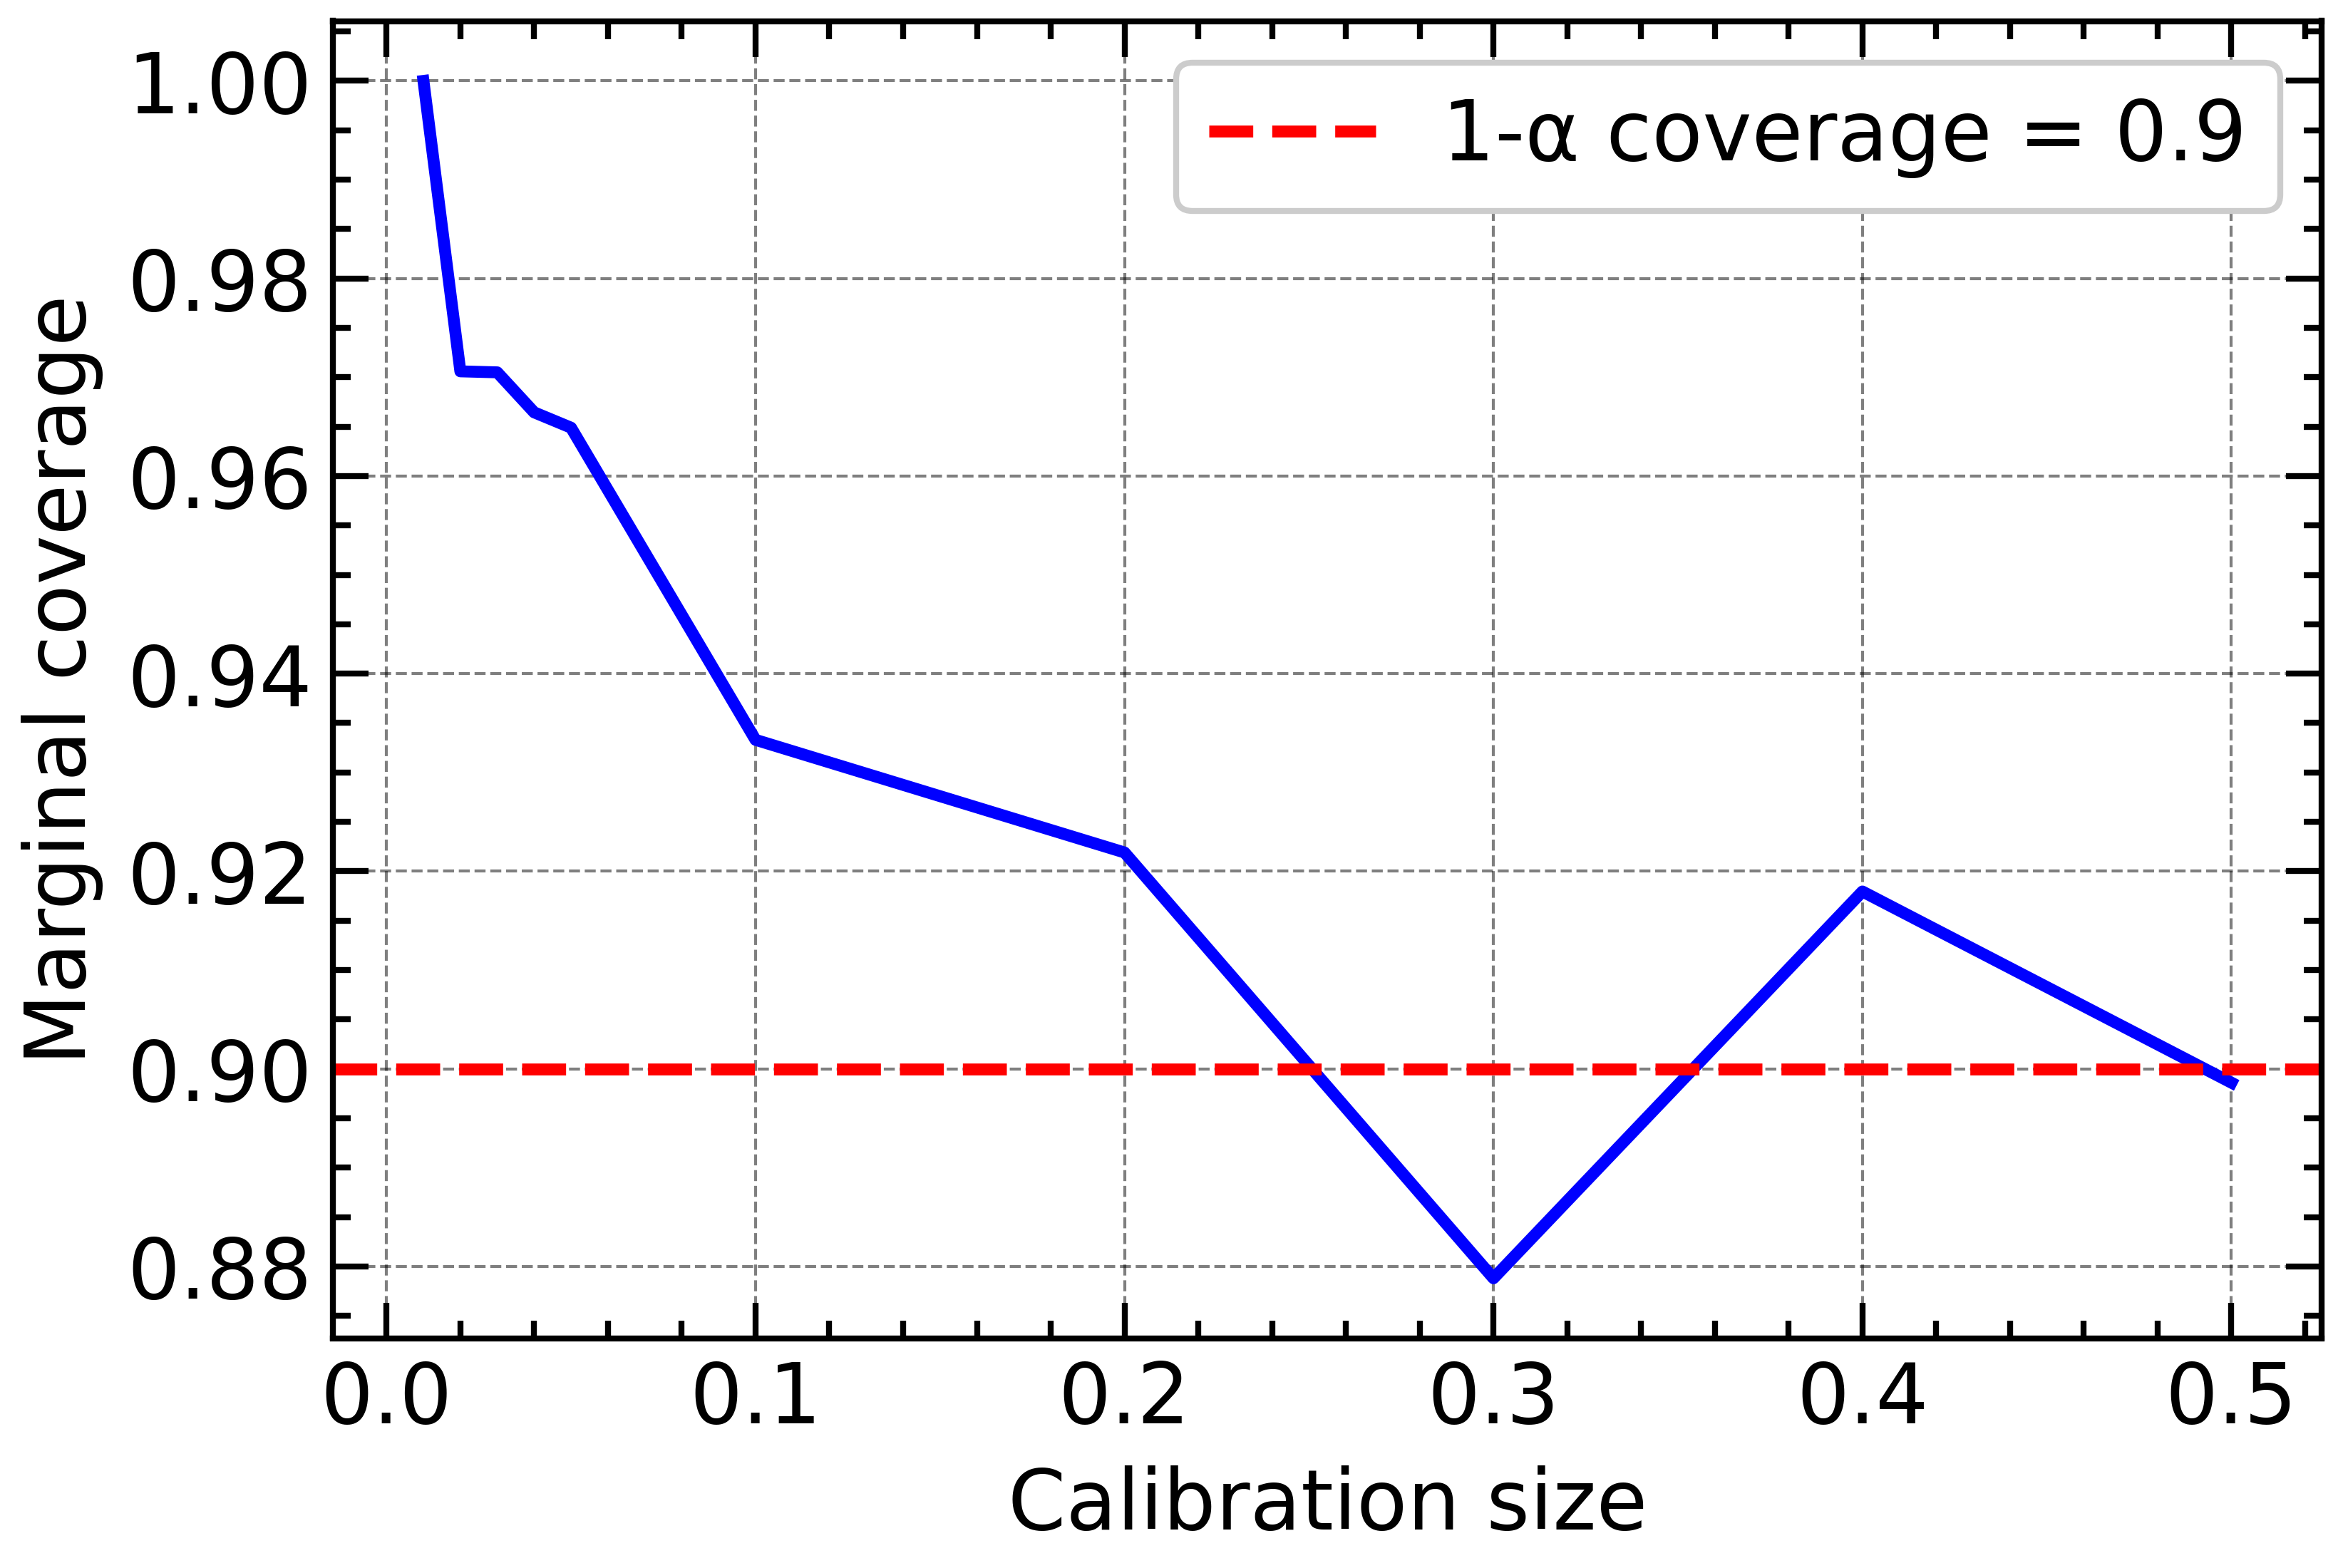

In [6]:

plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(6, 4))
plt.plot(indices, cov1_list, color="b")
plt.axhline(y=0.9, linestyle="--", color="r", label="1-α coverage = 0.9")
plt.ylabel("Marginal coverage")
plt.xlabel("Calibration size")
plt.legend()

# plt.savefig('coverage_calibration_prostate.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


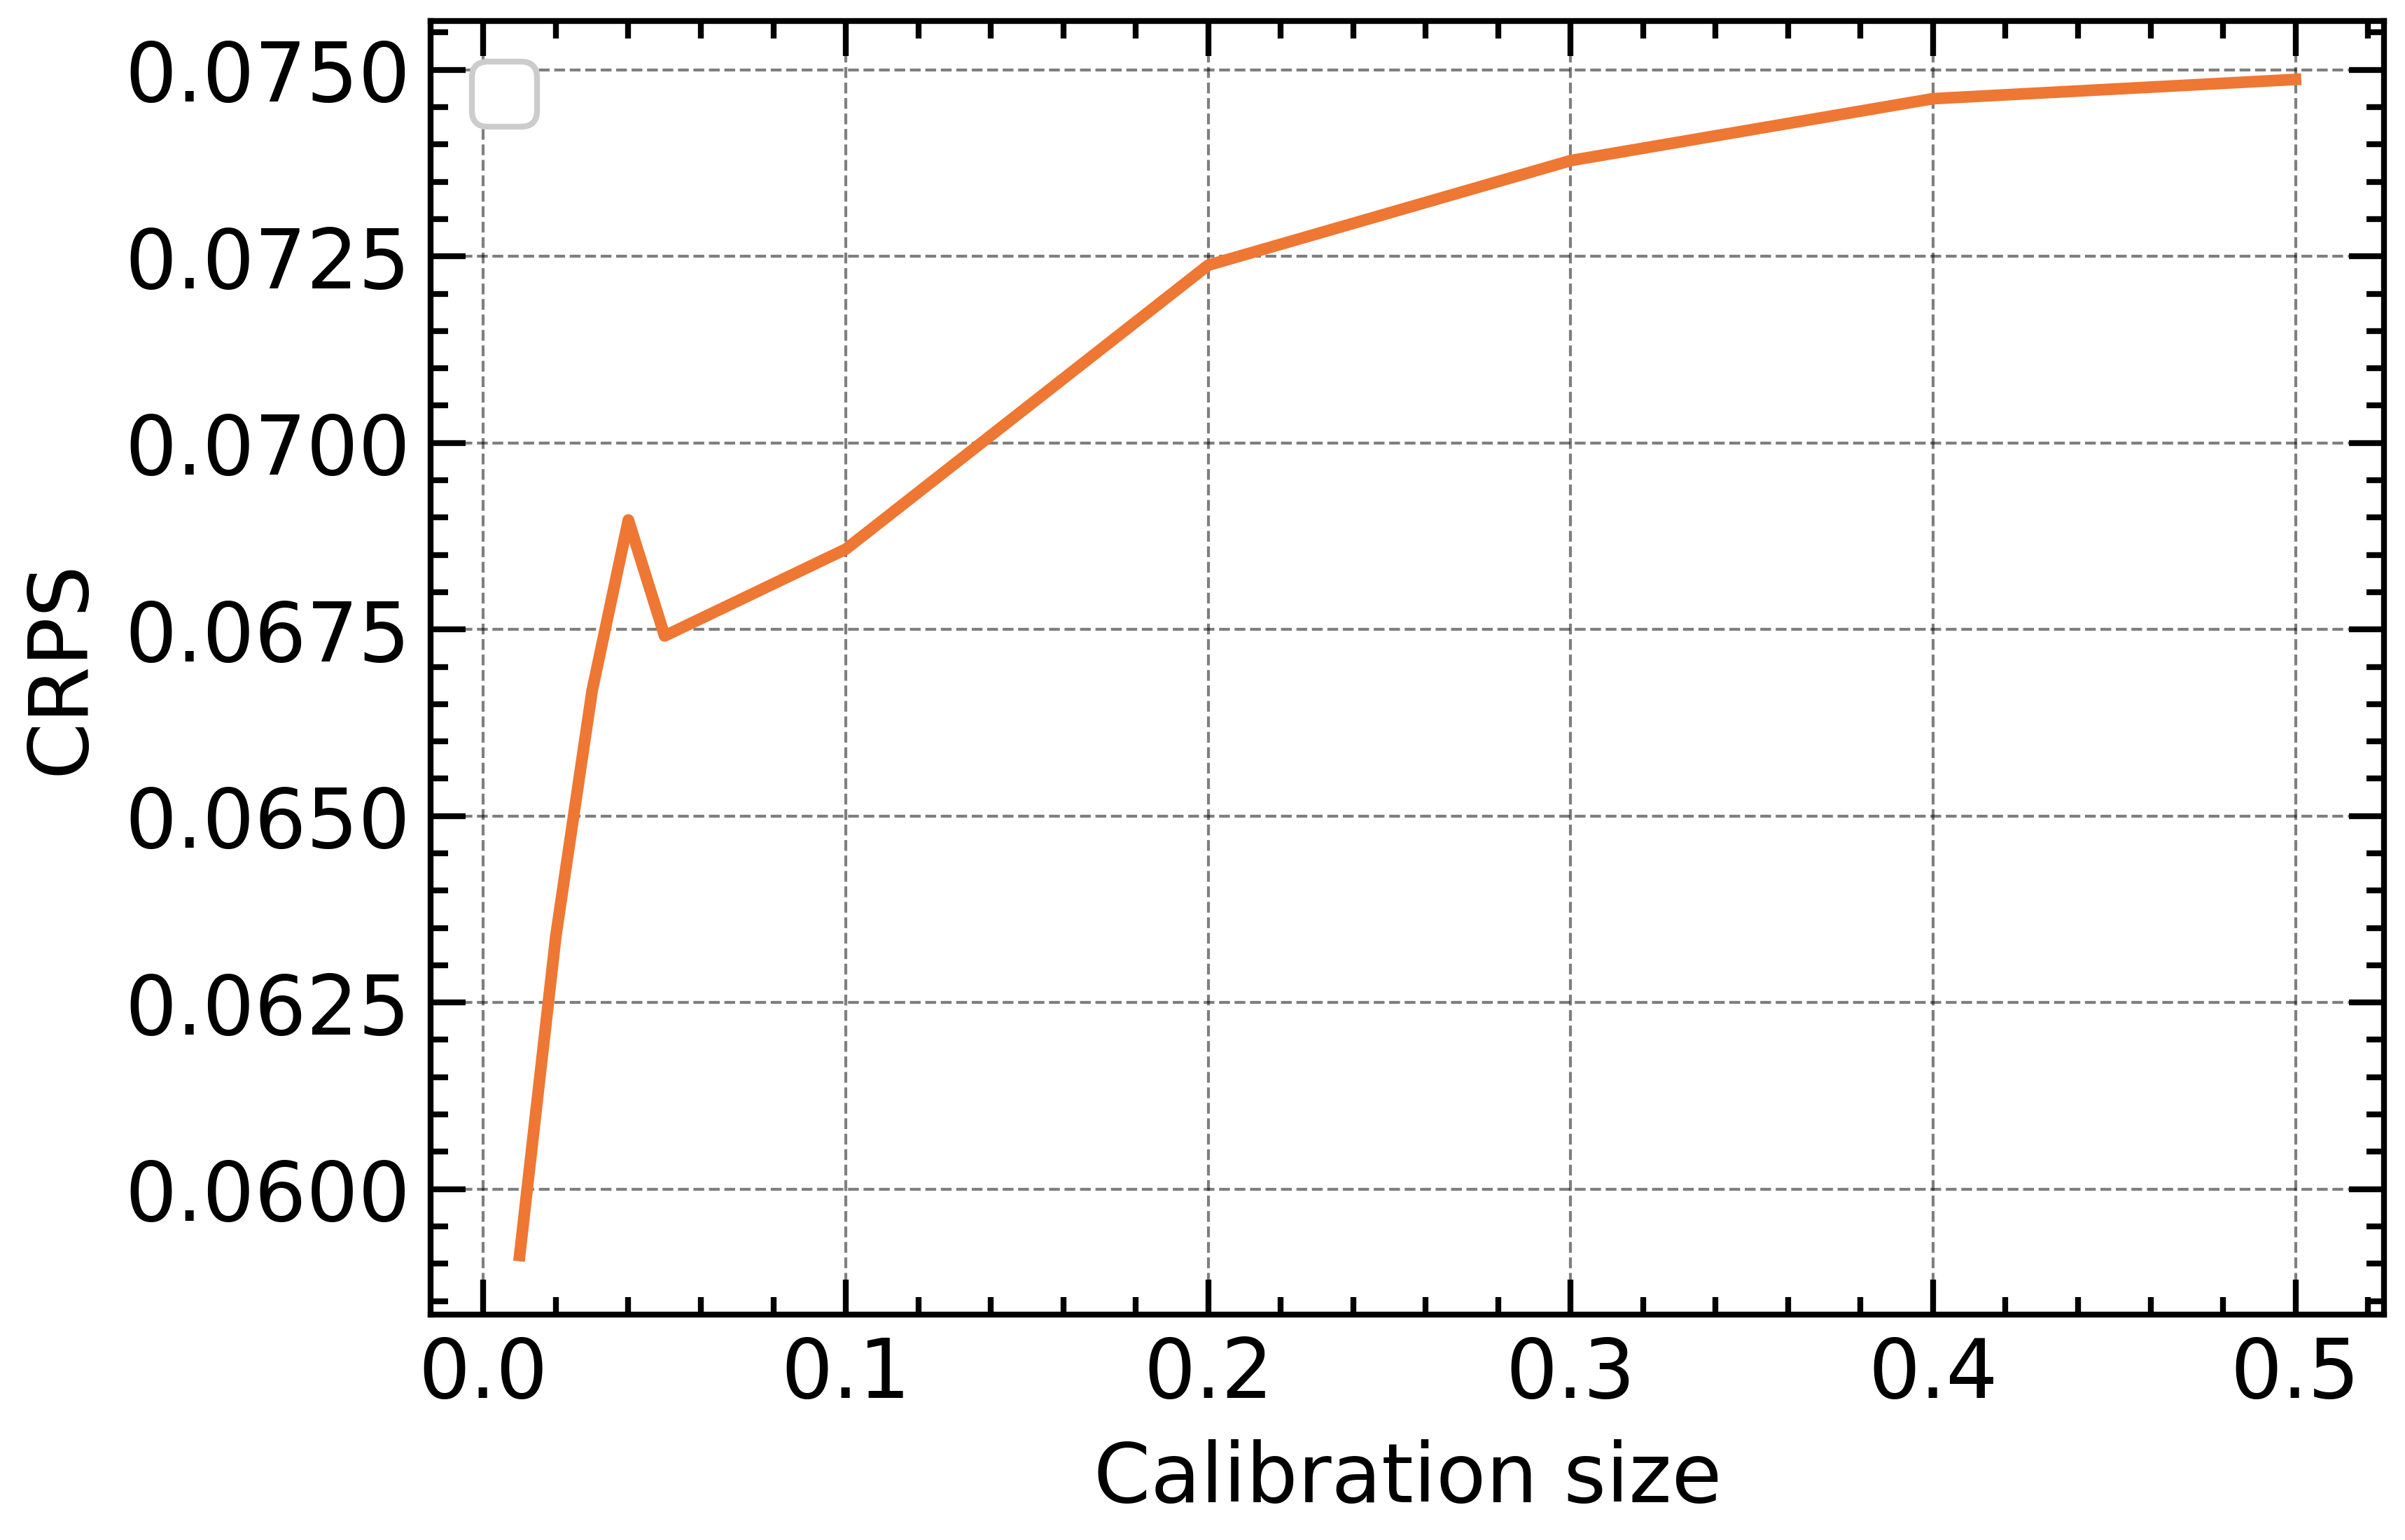

In [7]:

crps1_list = []
crps2_list = []
for idx in indices:
    crps1 = np.median(np.mean(full_crps[idx], axis=-1))
    crps2 = np.median(full_crps[idx][:, -1])

    crps1 = np.median(np.mean(full_crps[idx], axis=-1))
    crps2 = np.median(full_crps[idx][:, -1])

    crps1_list.append(crps1)
    crps2_list.append(crps2)


plt.figure(figsize=(6, 4))

plt.plot(indices, savgol_filter(crps1_list, 7, 2))

plt.ylabel("CRPS")
plt.xlabel("Calibration size")
plt.legend()
# plt.savefig('CRPS_score_prostate.pdf')

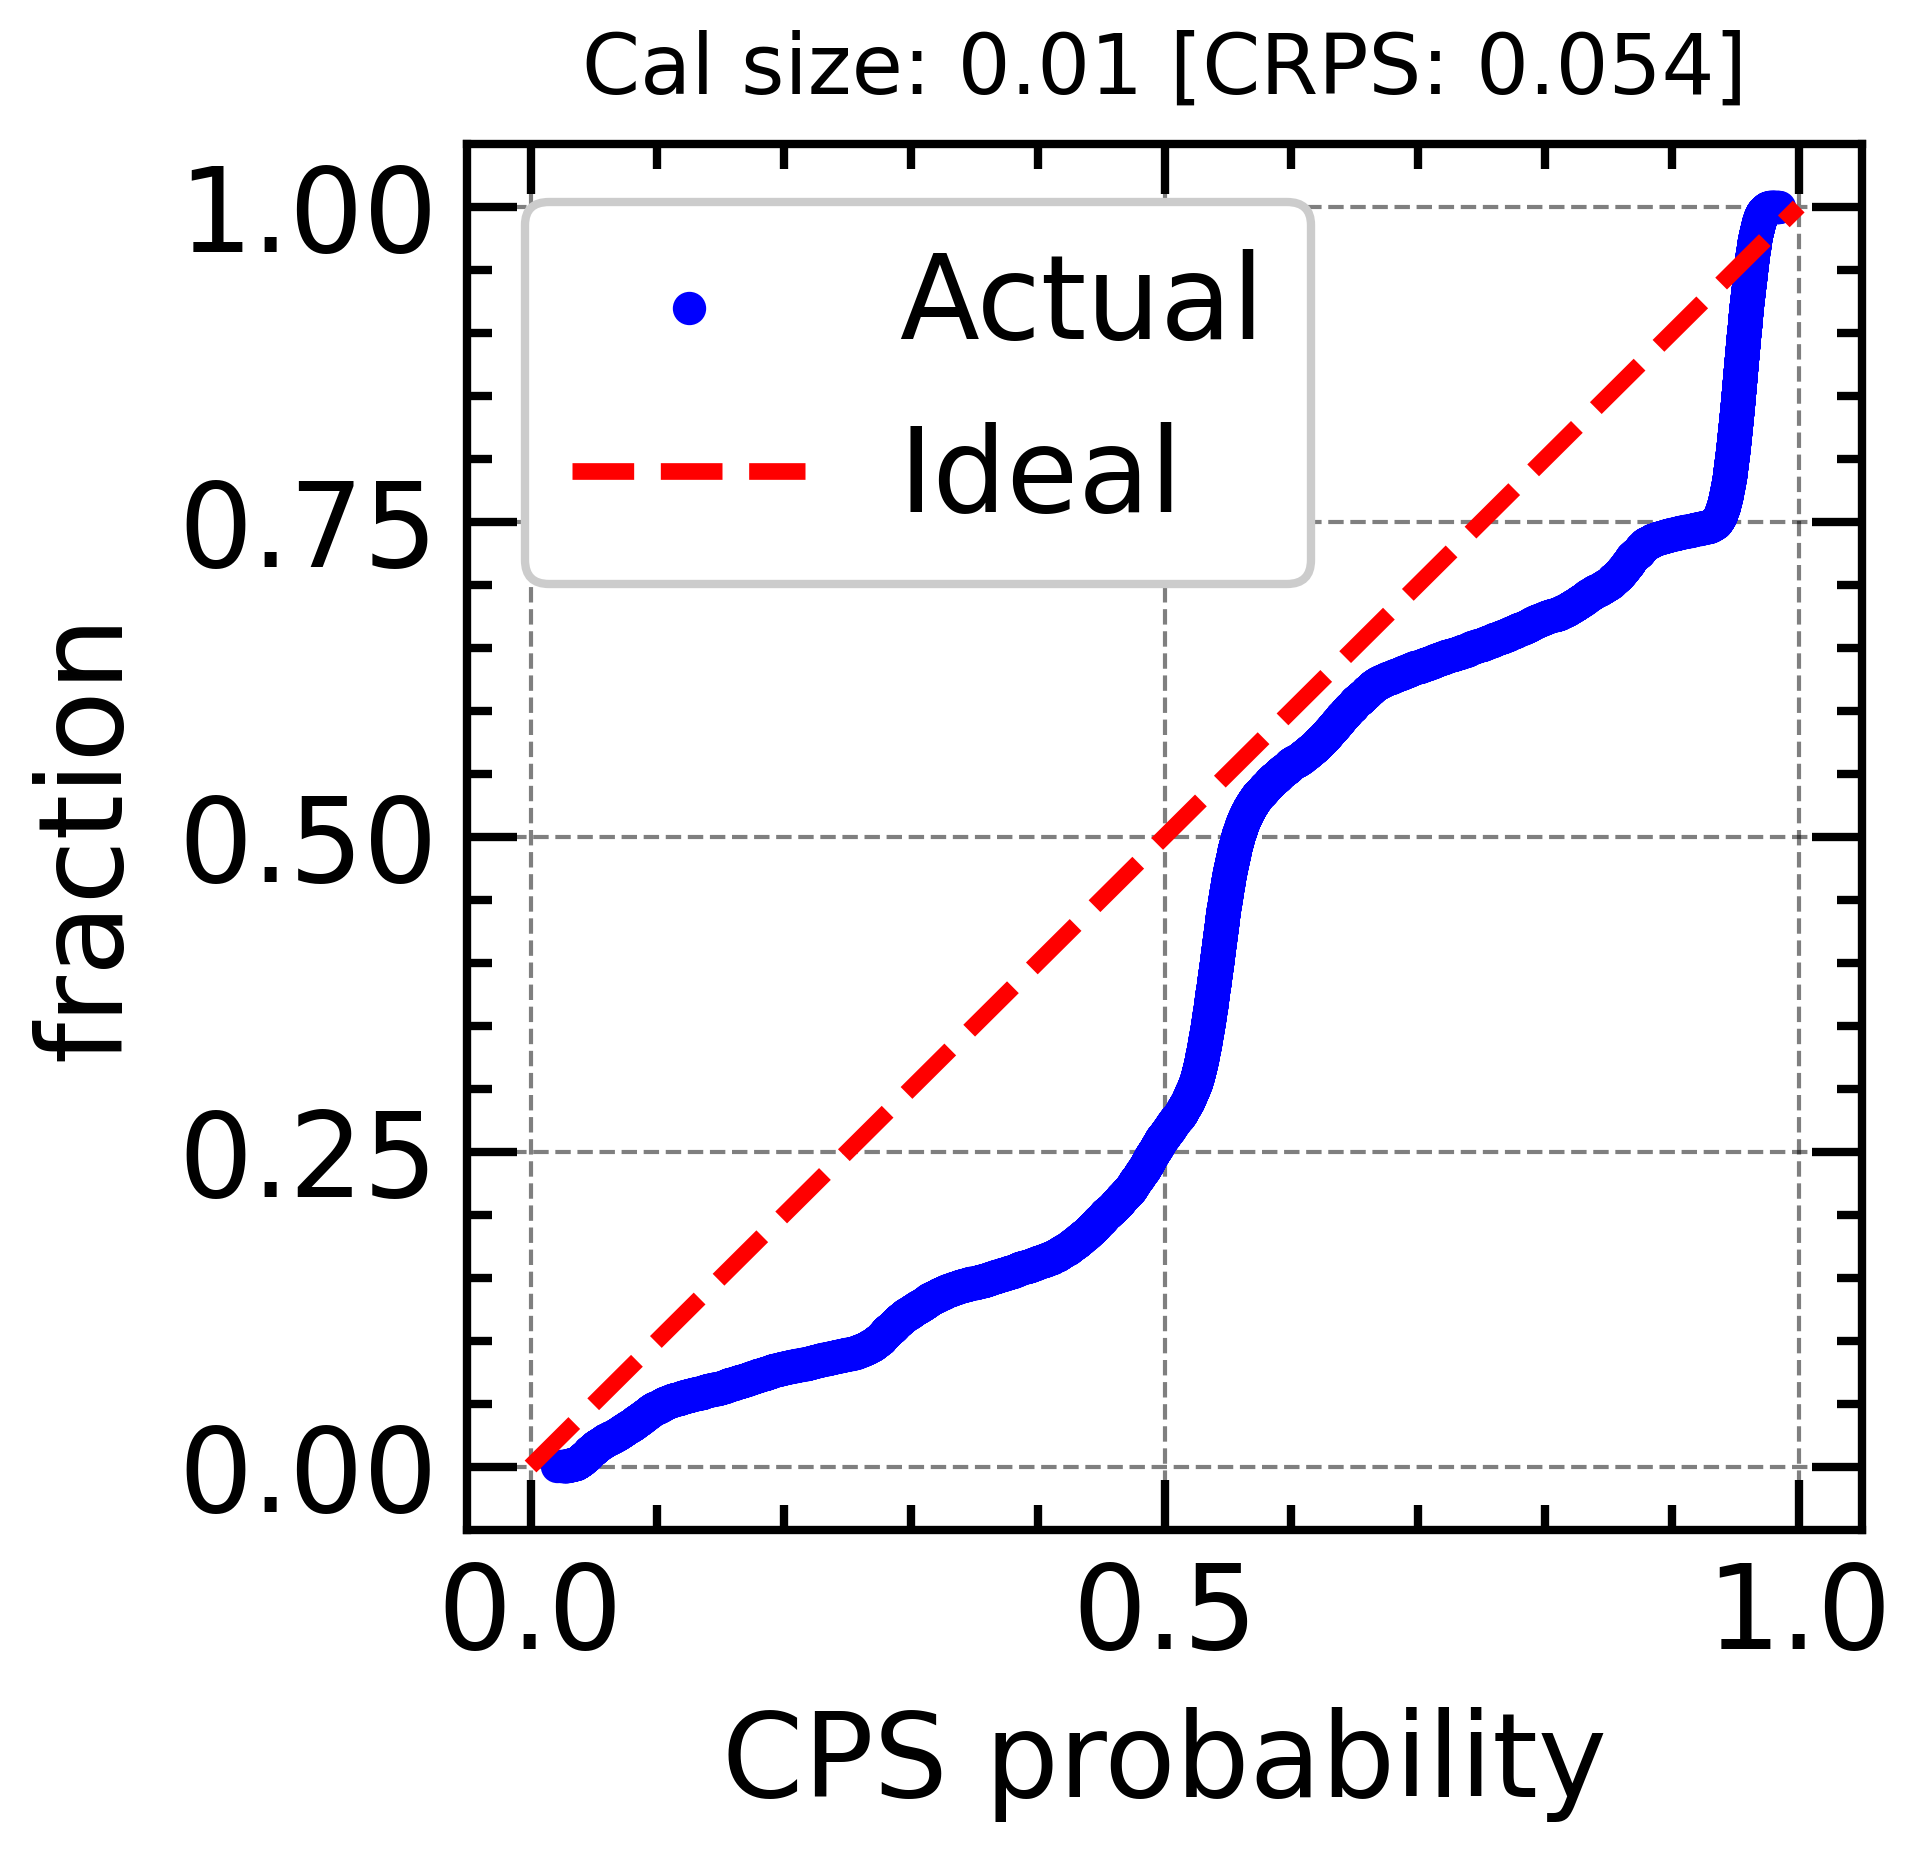

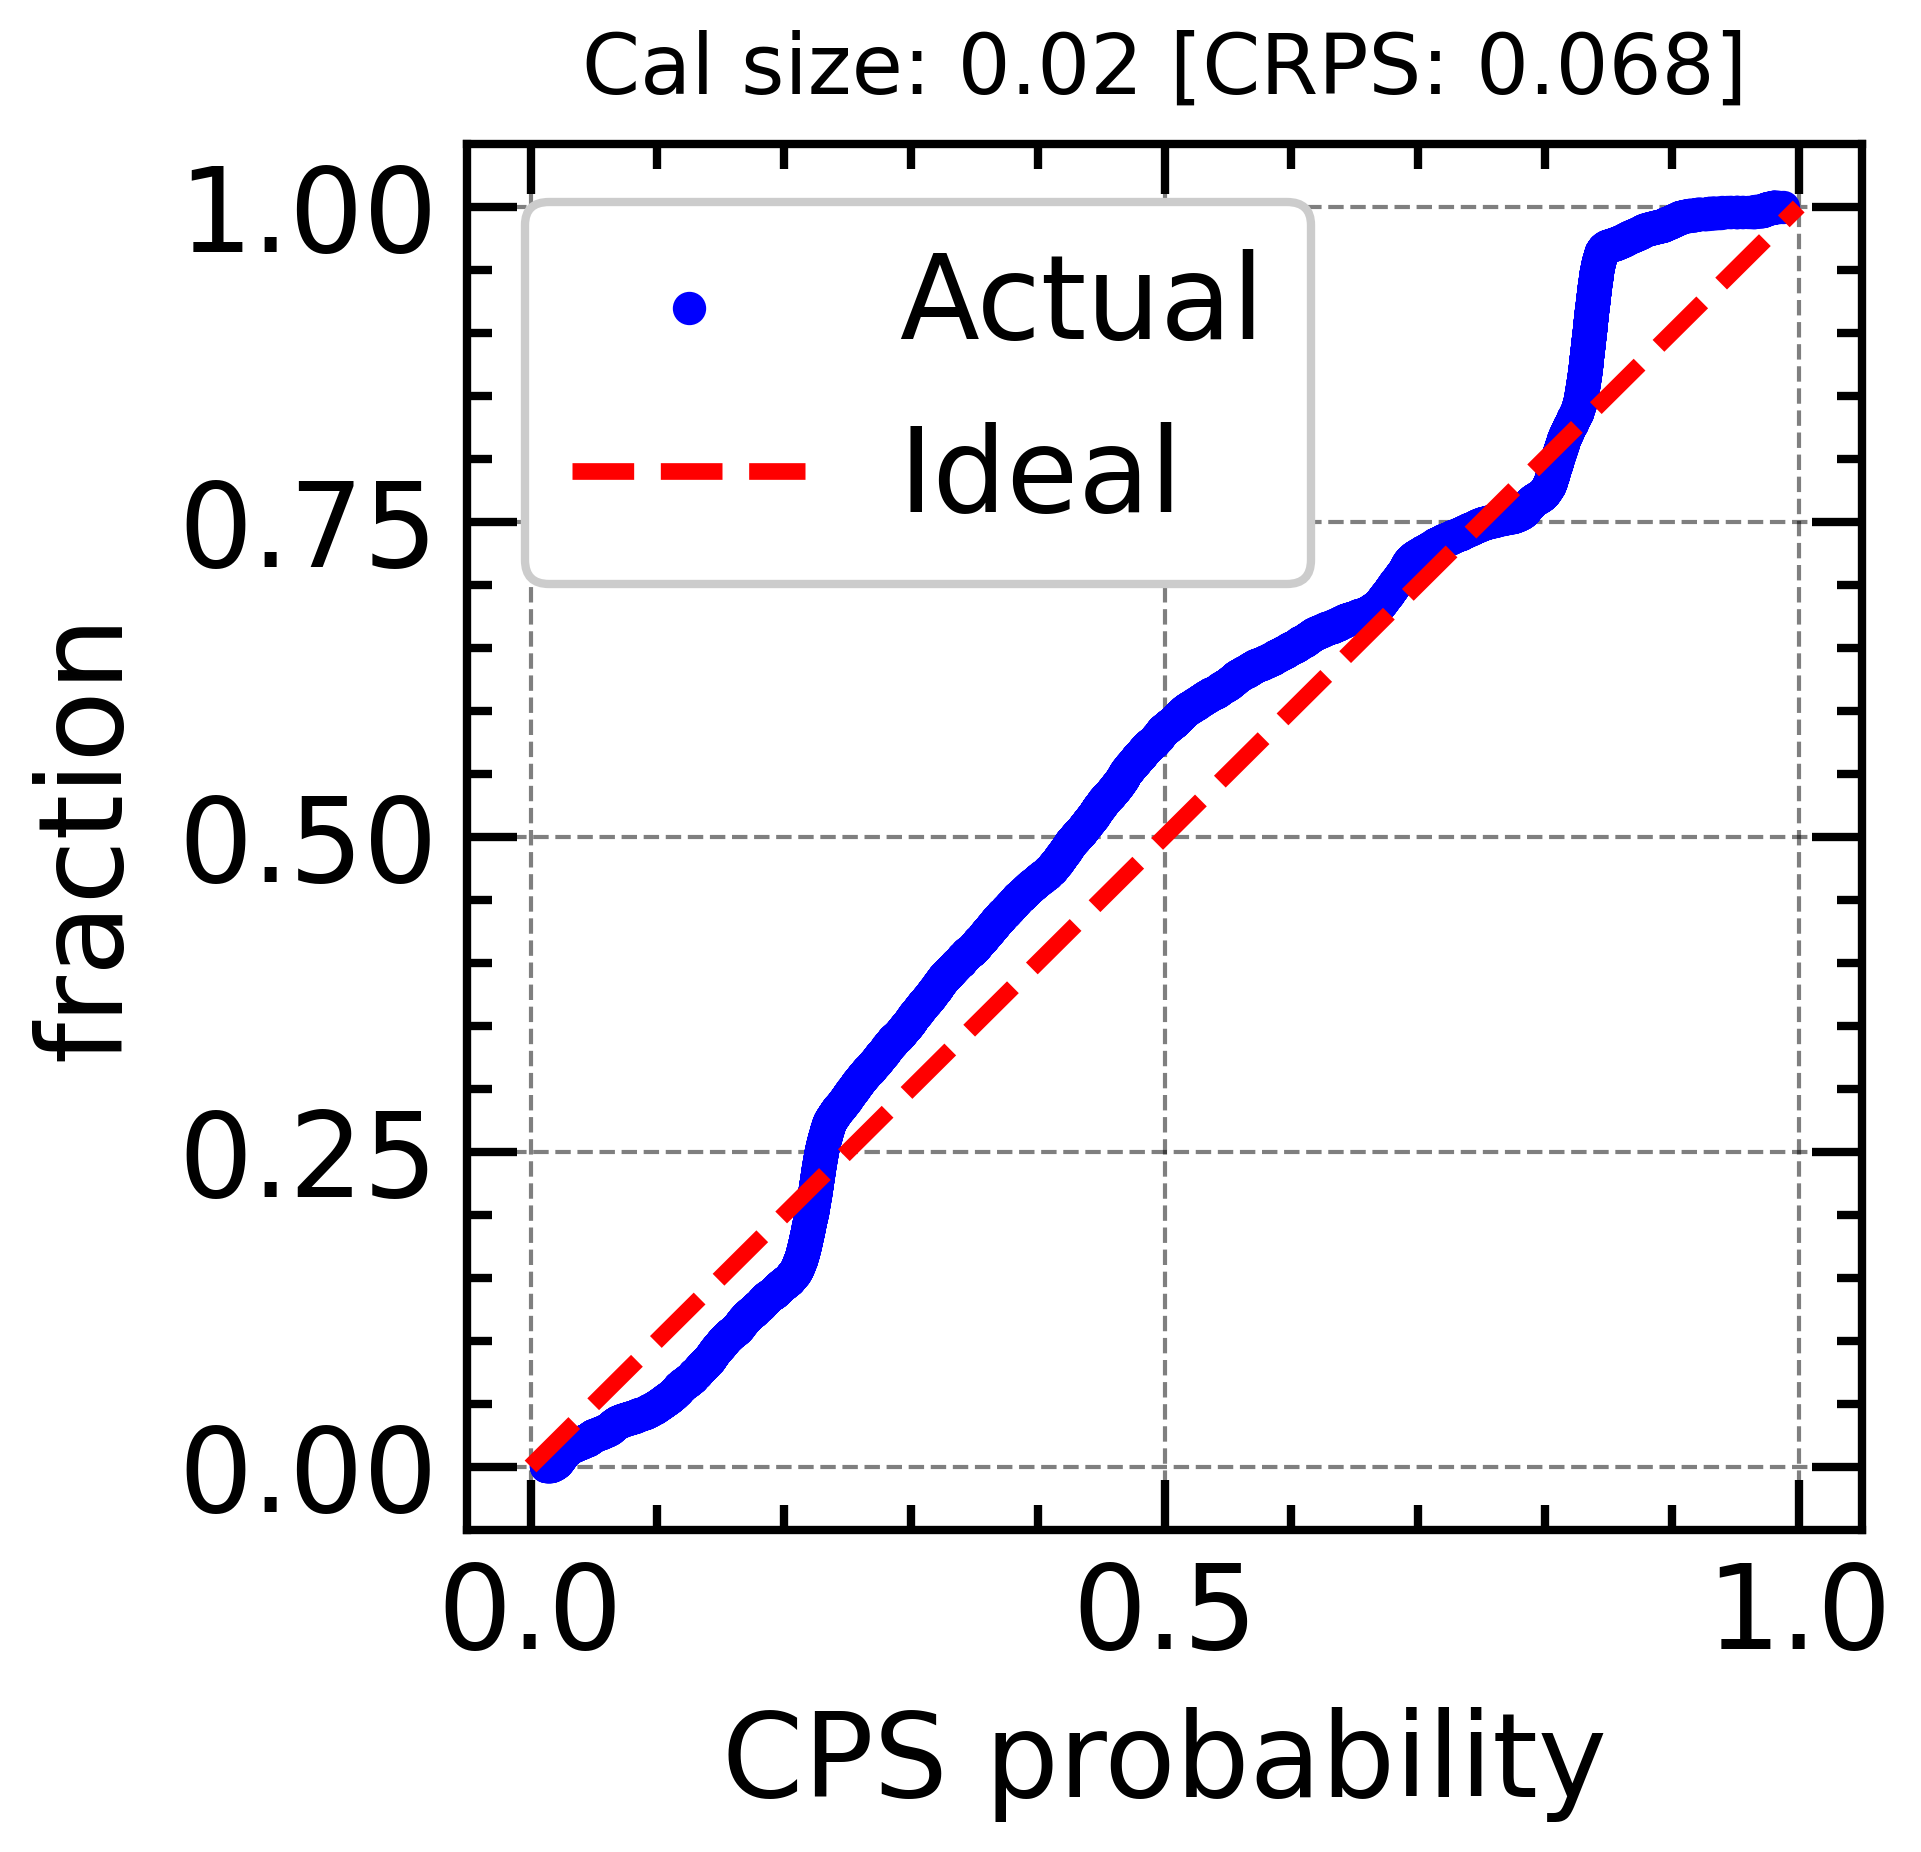

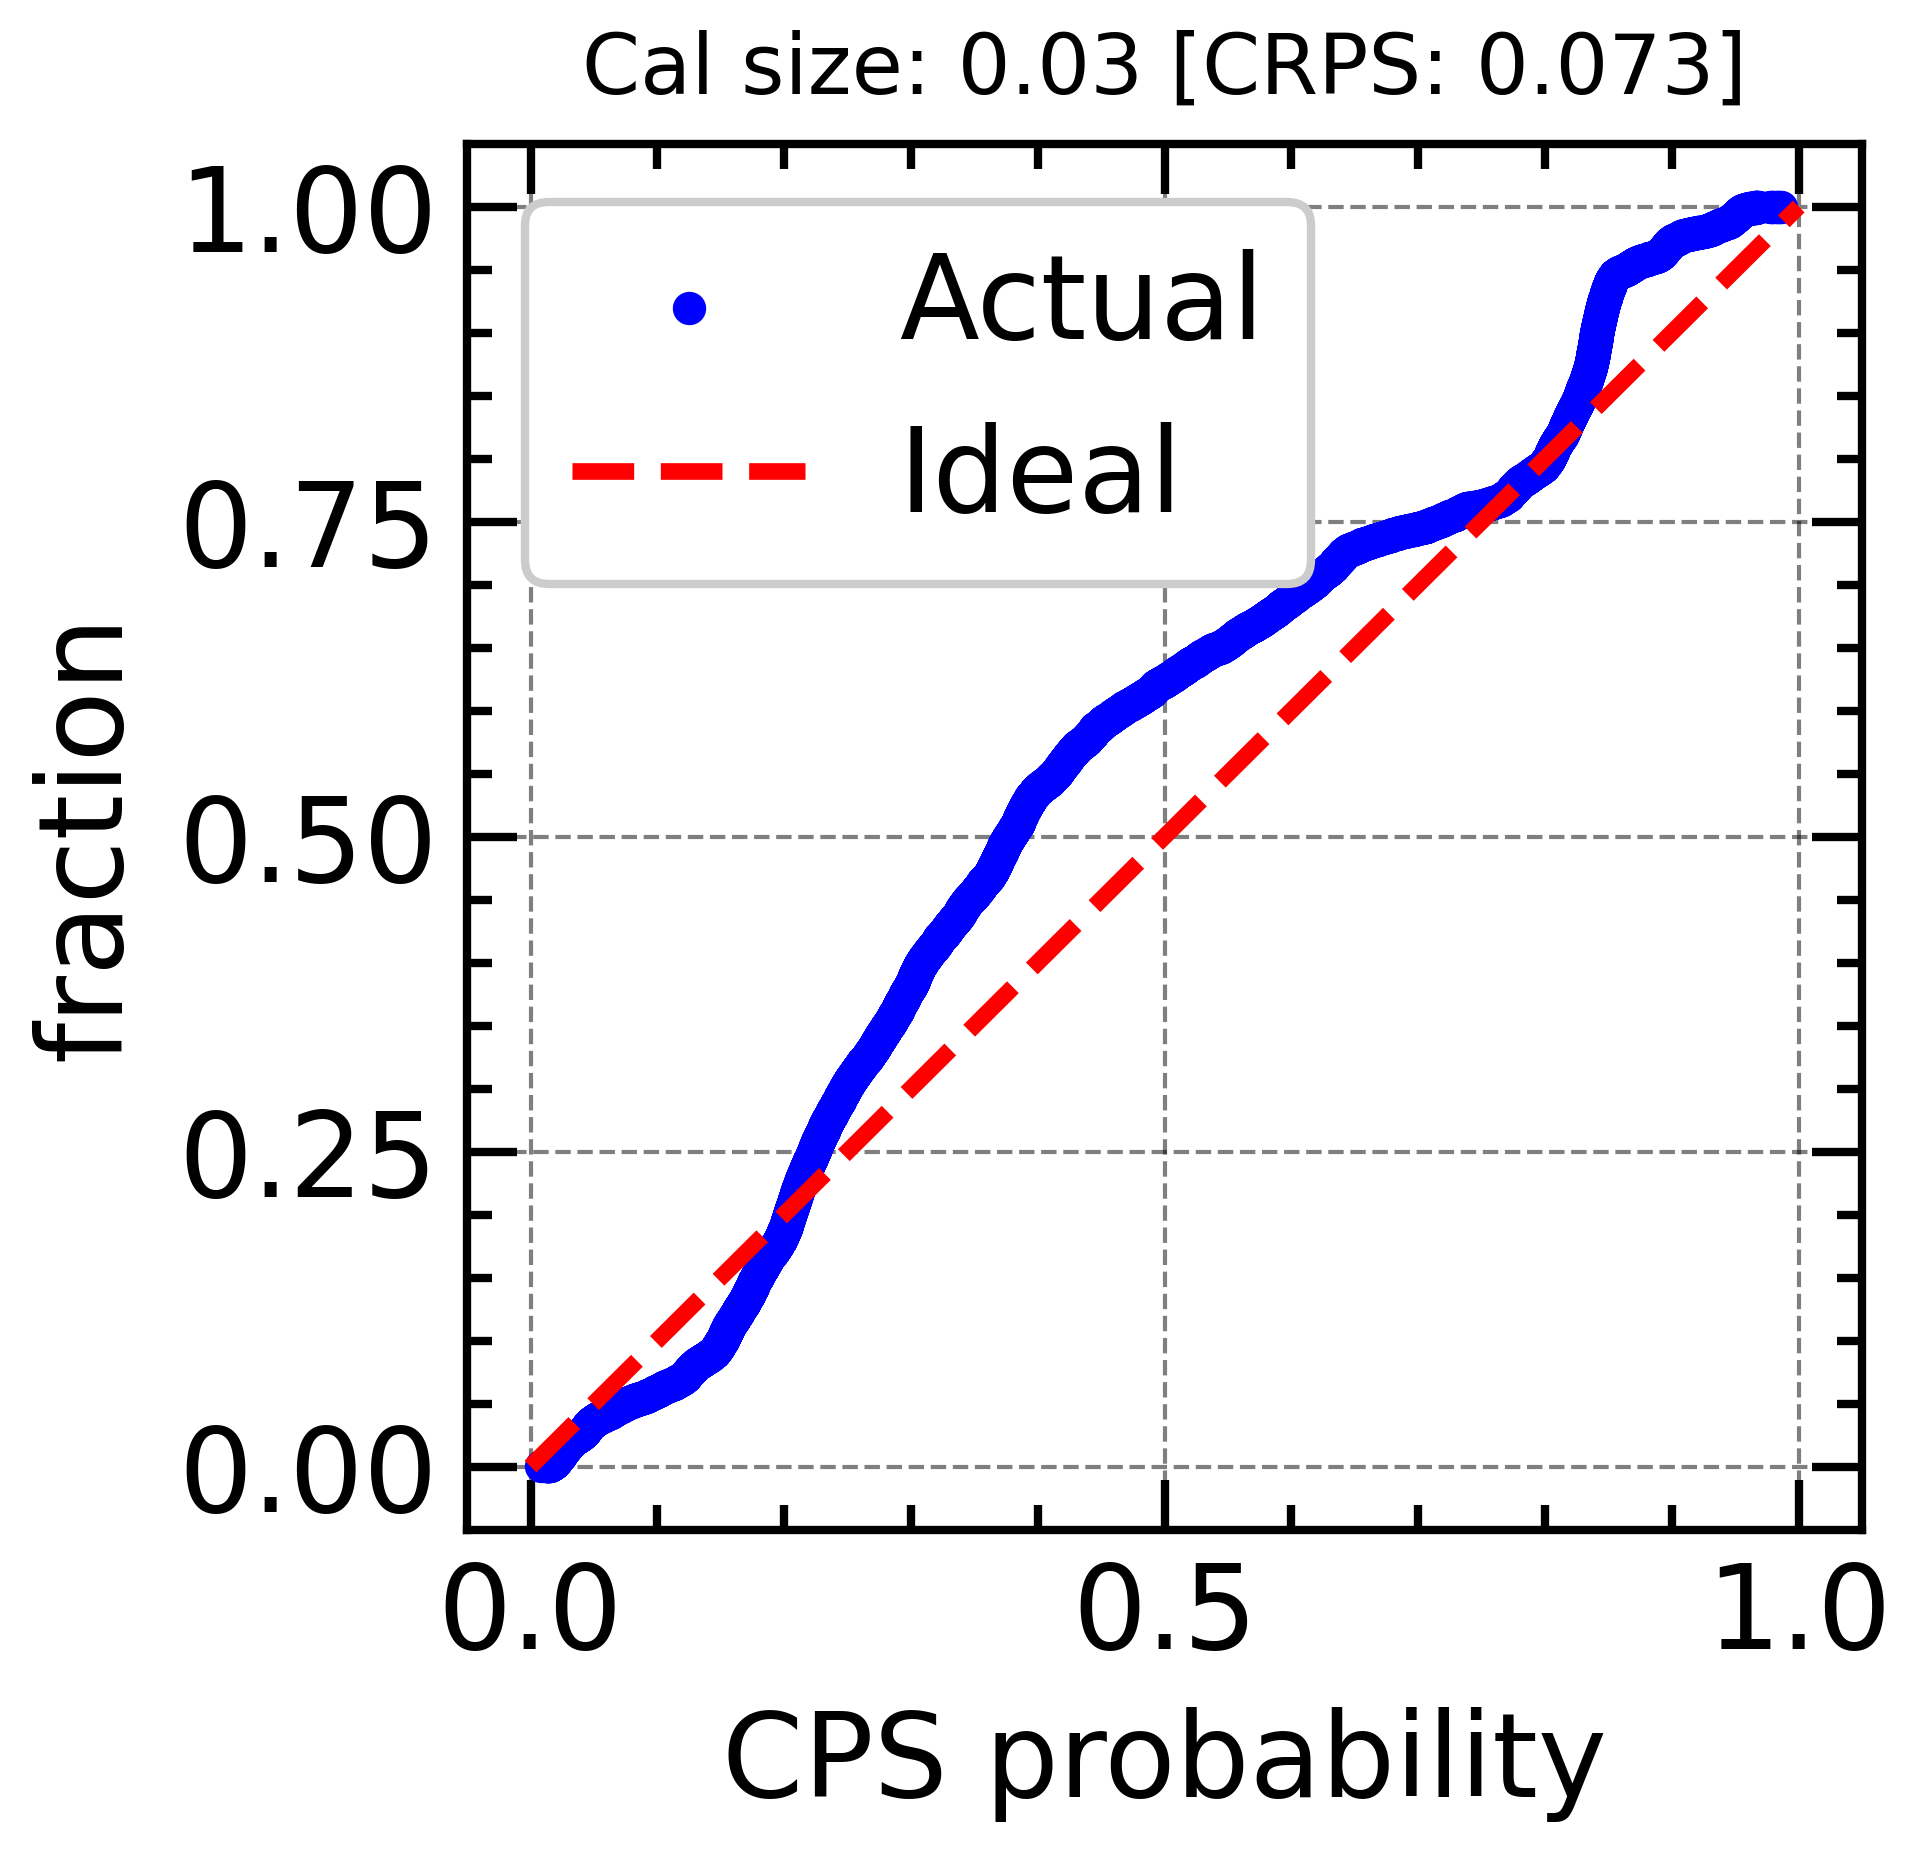

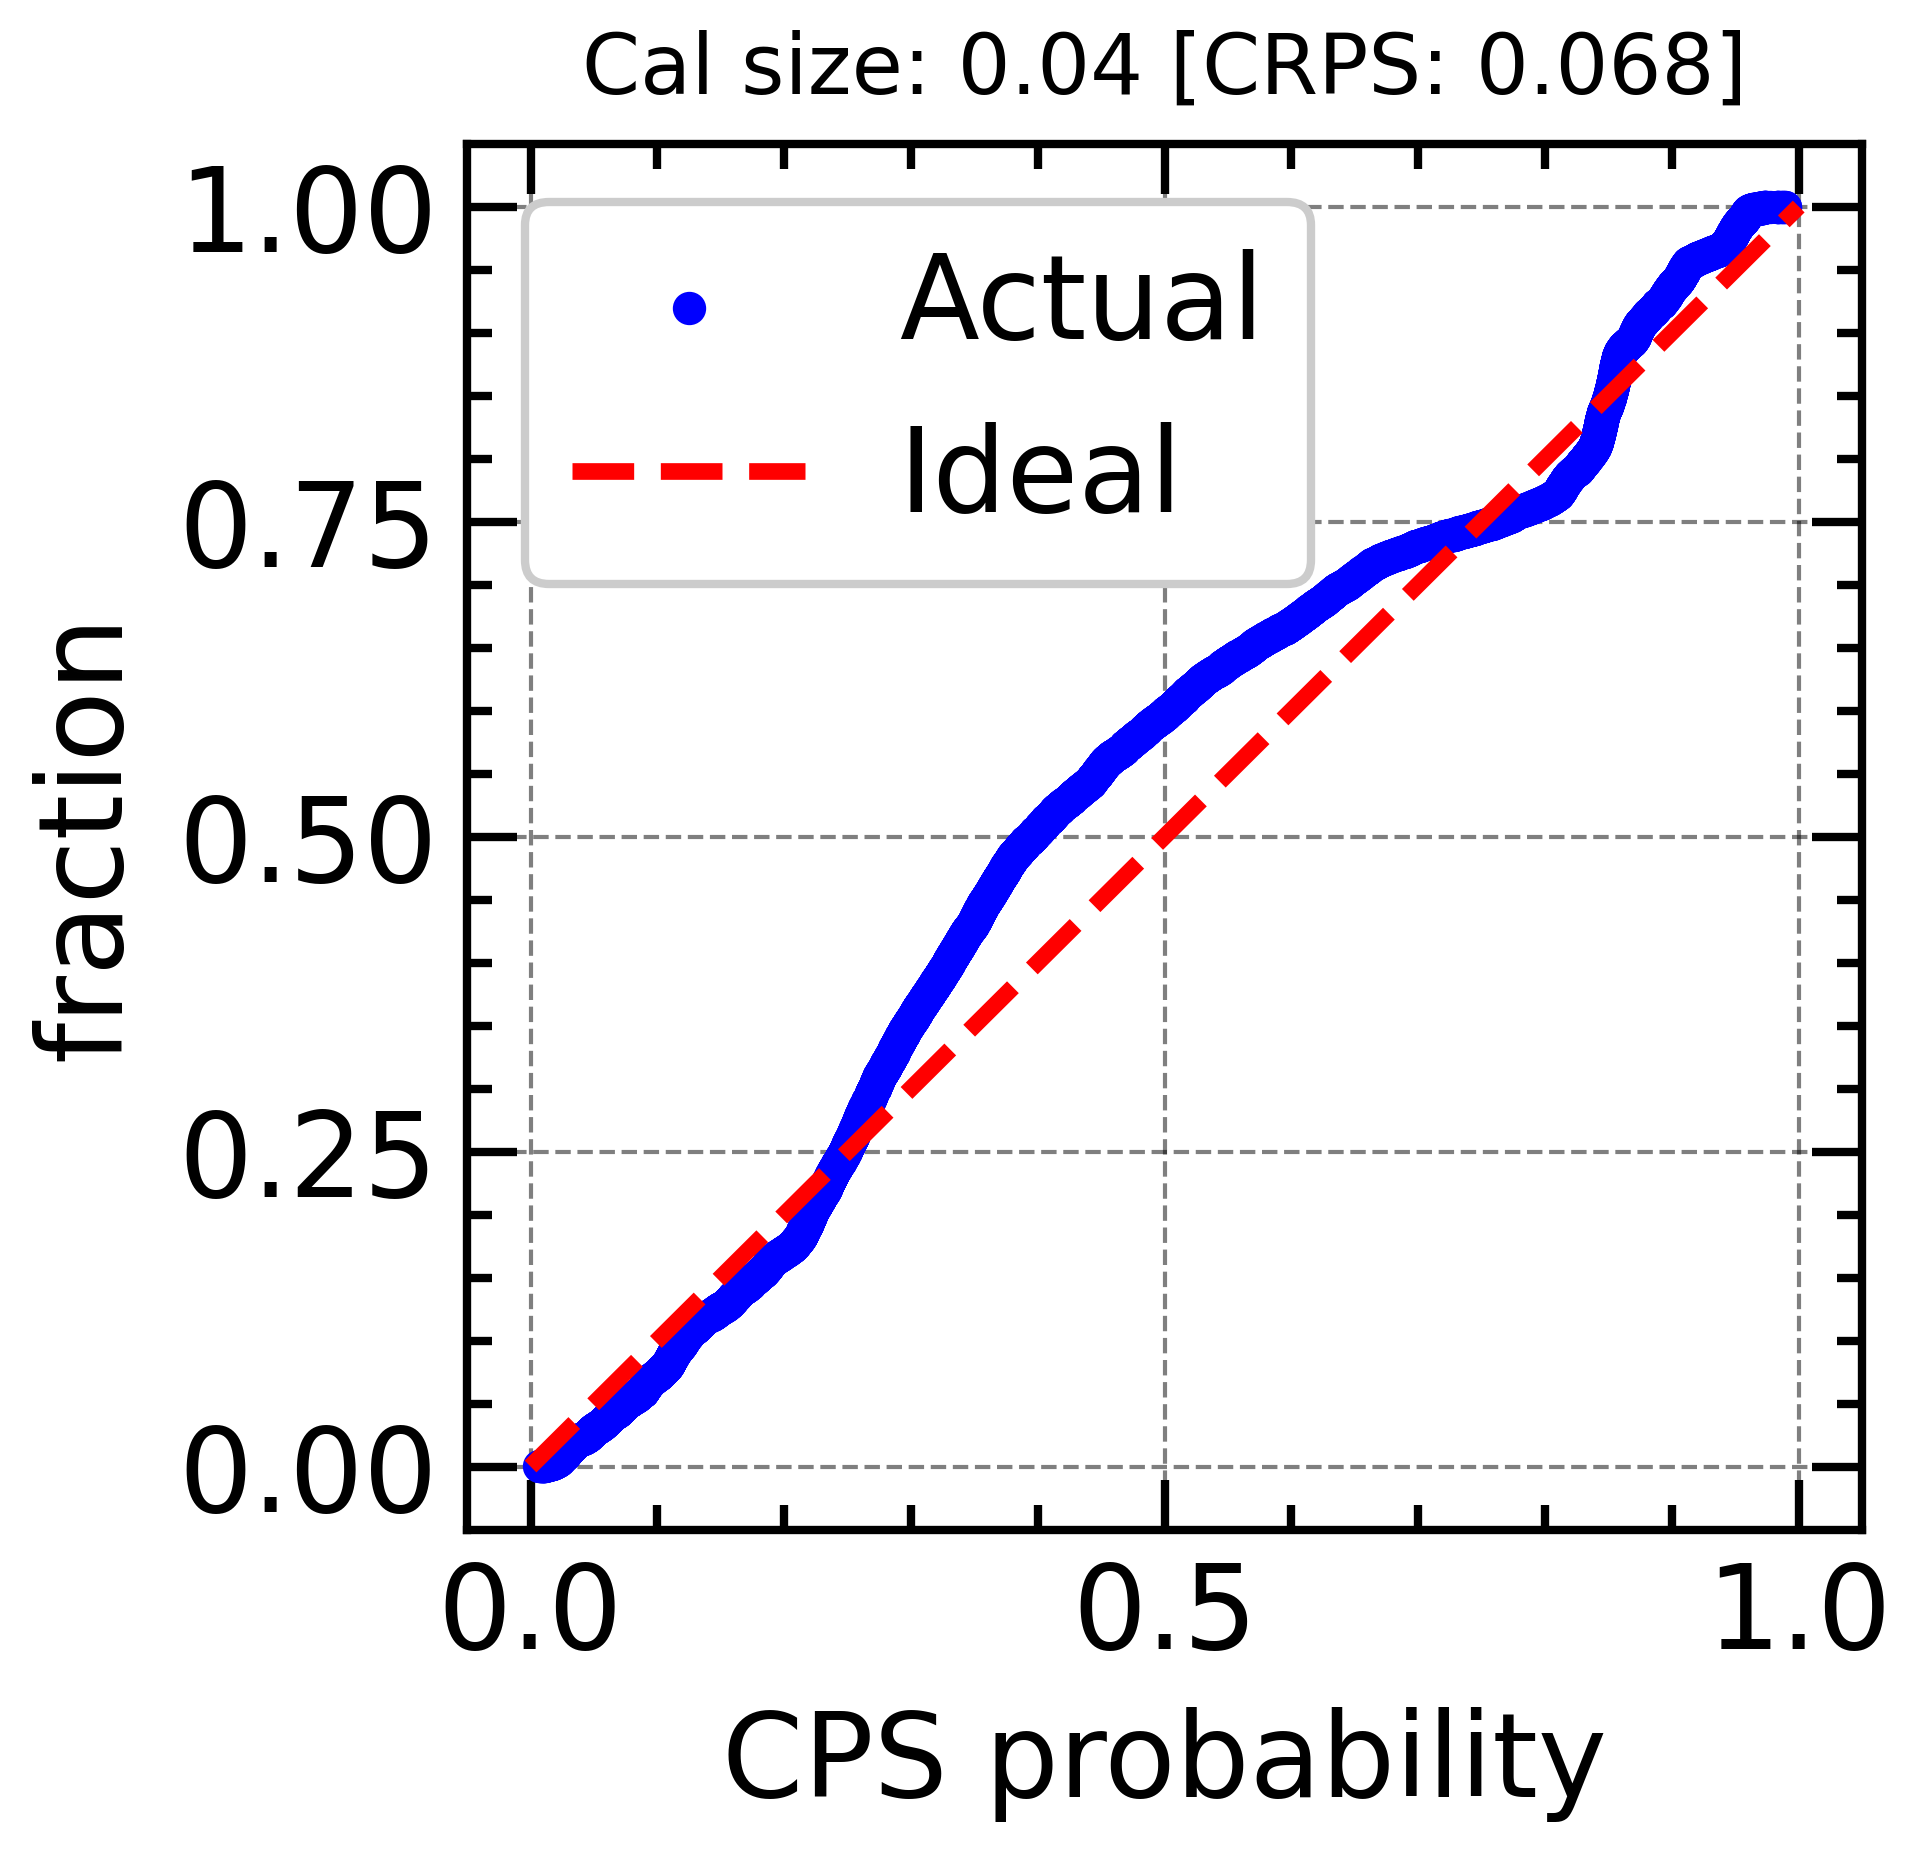

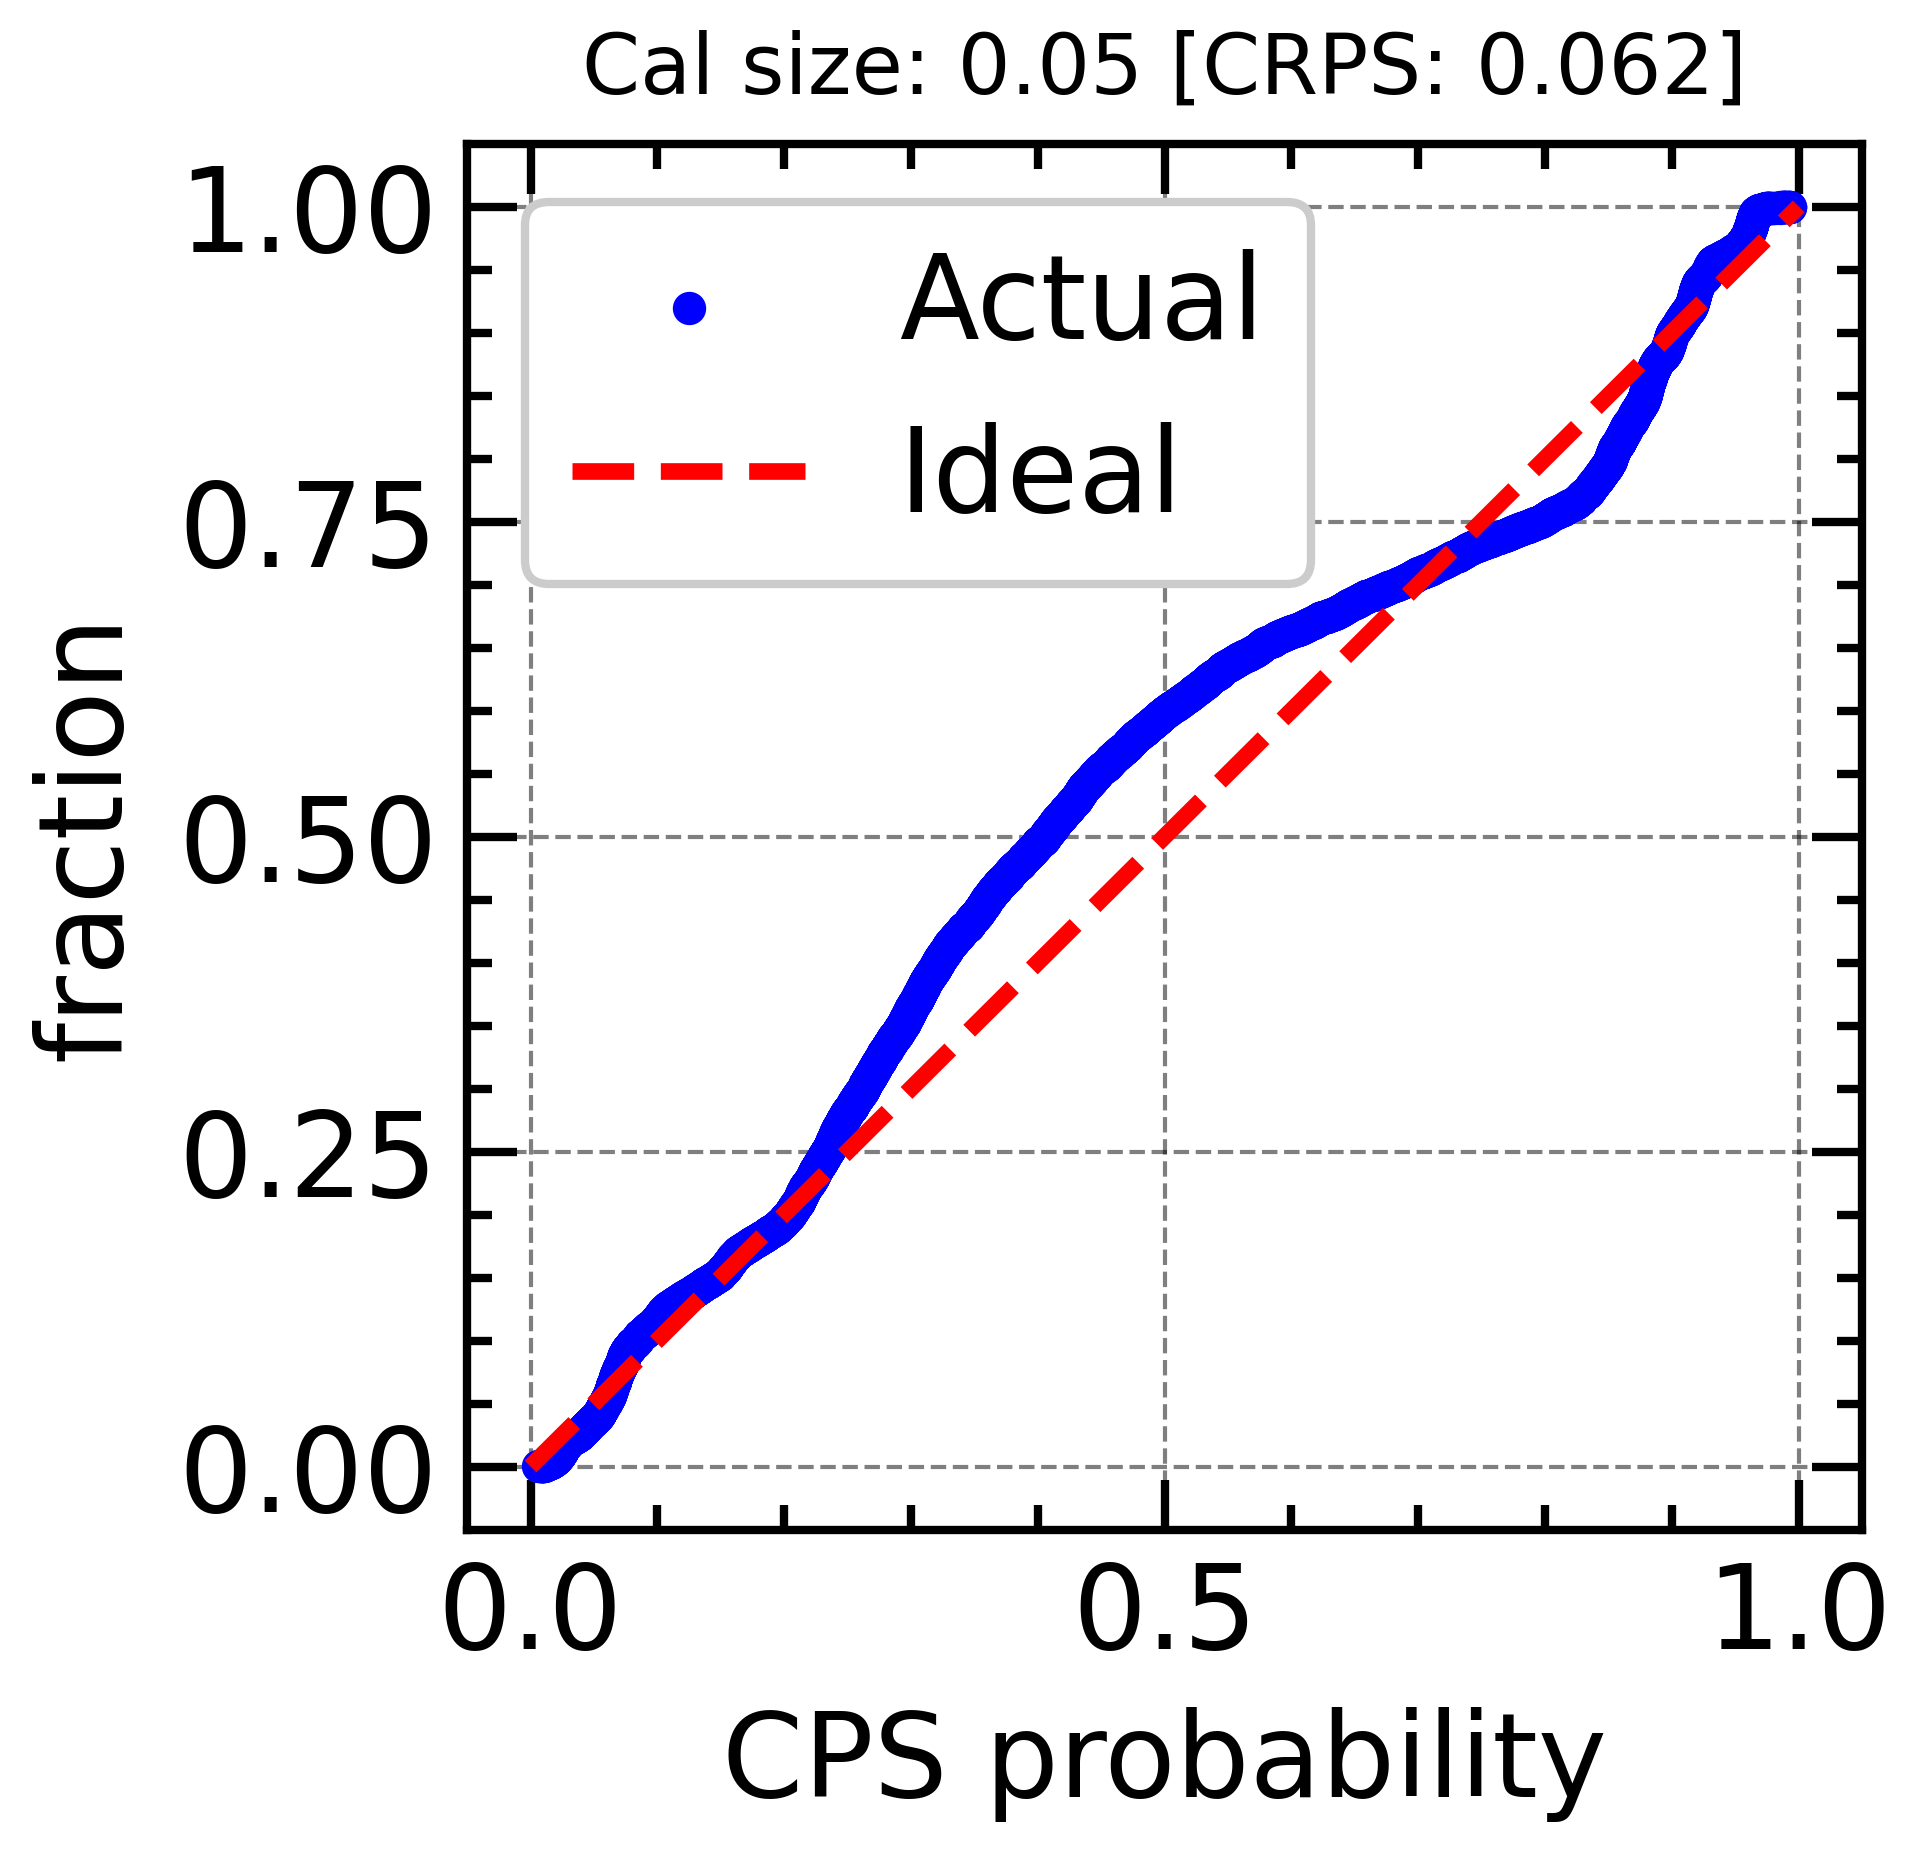

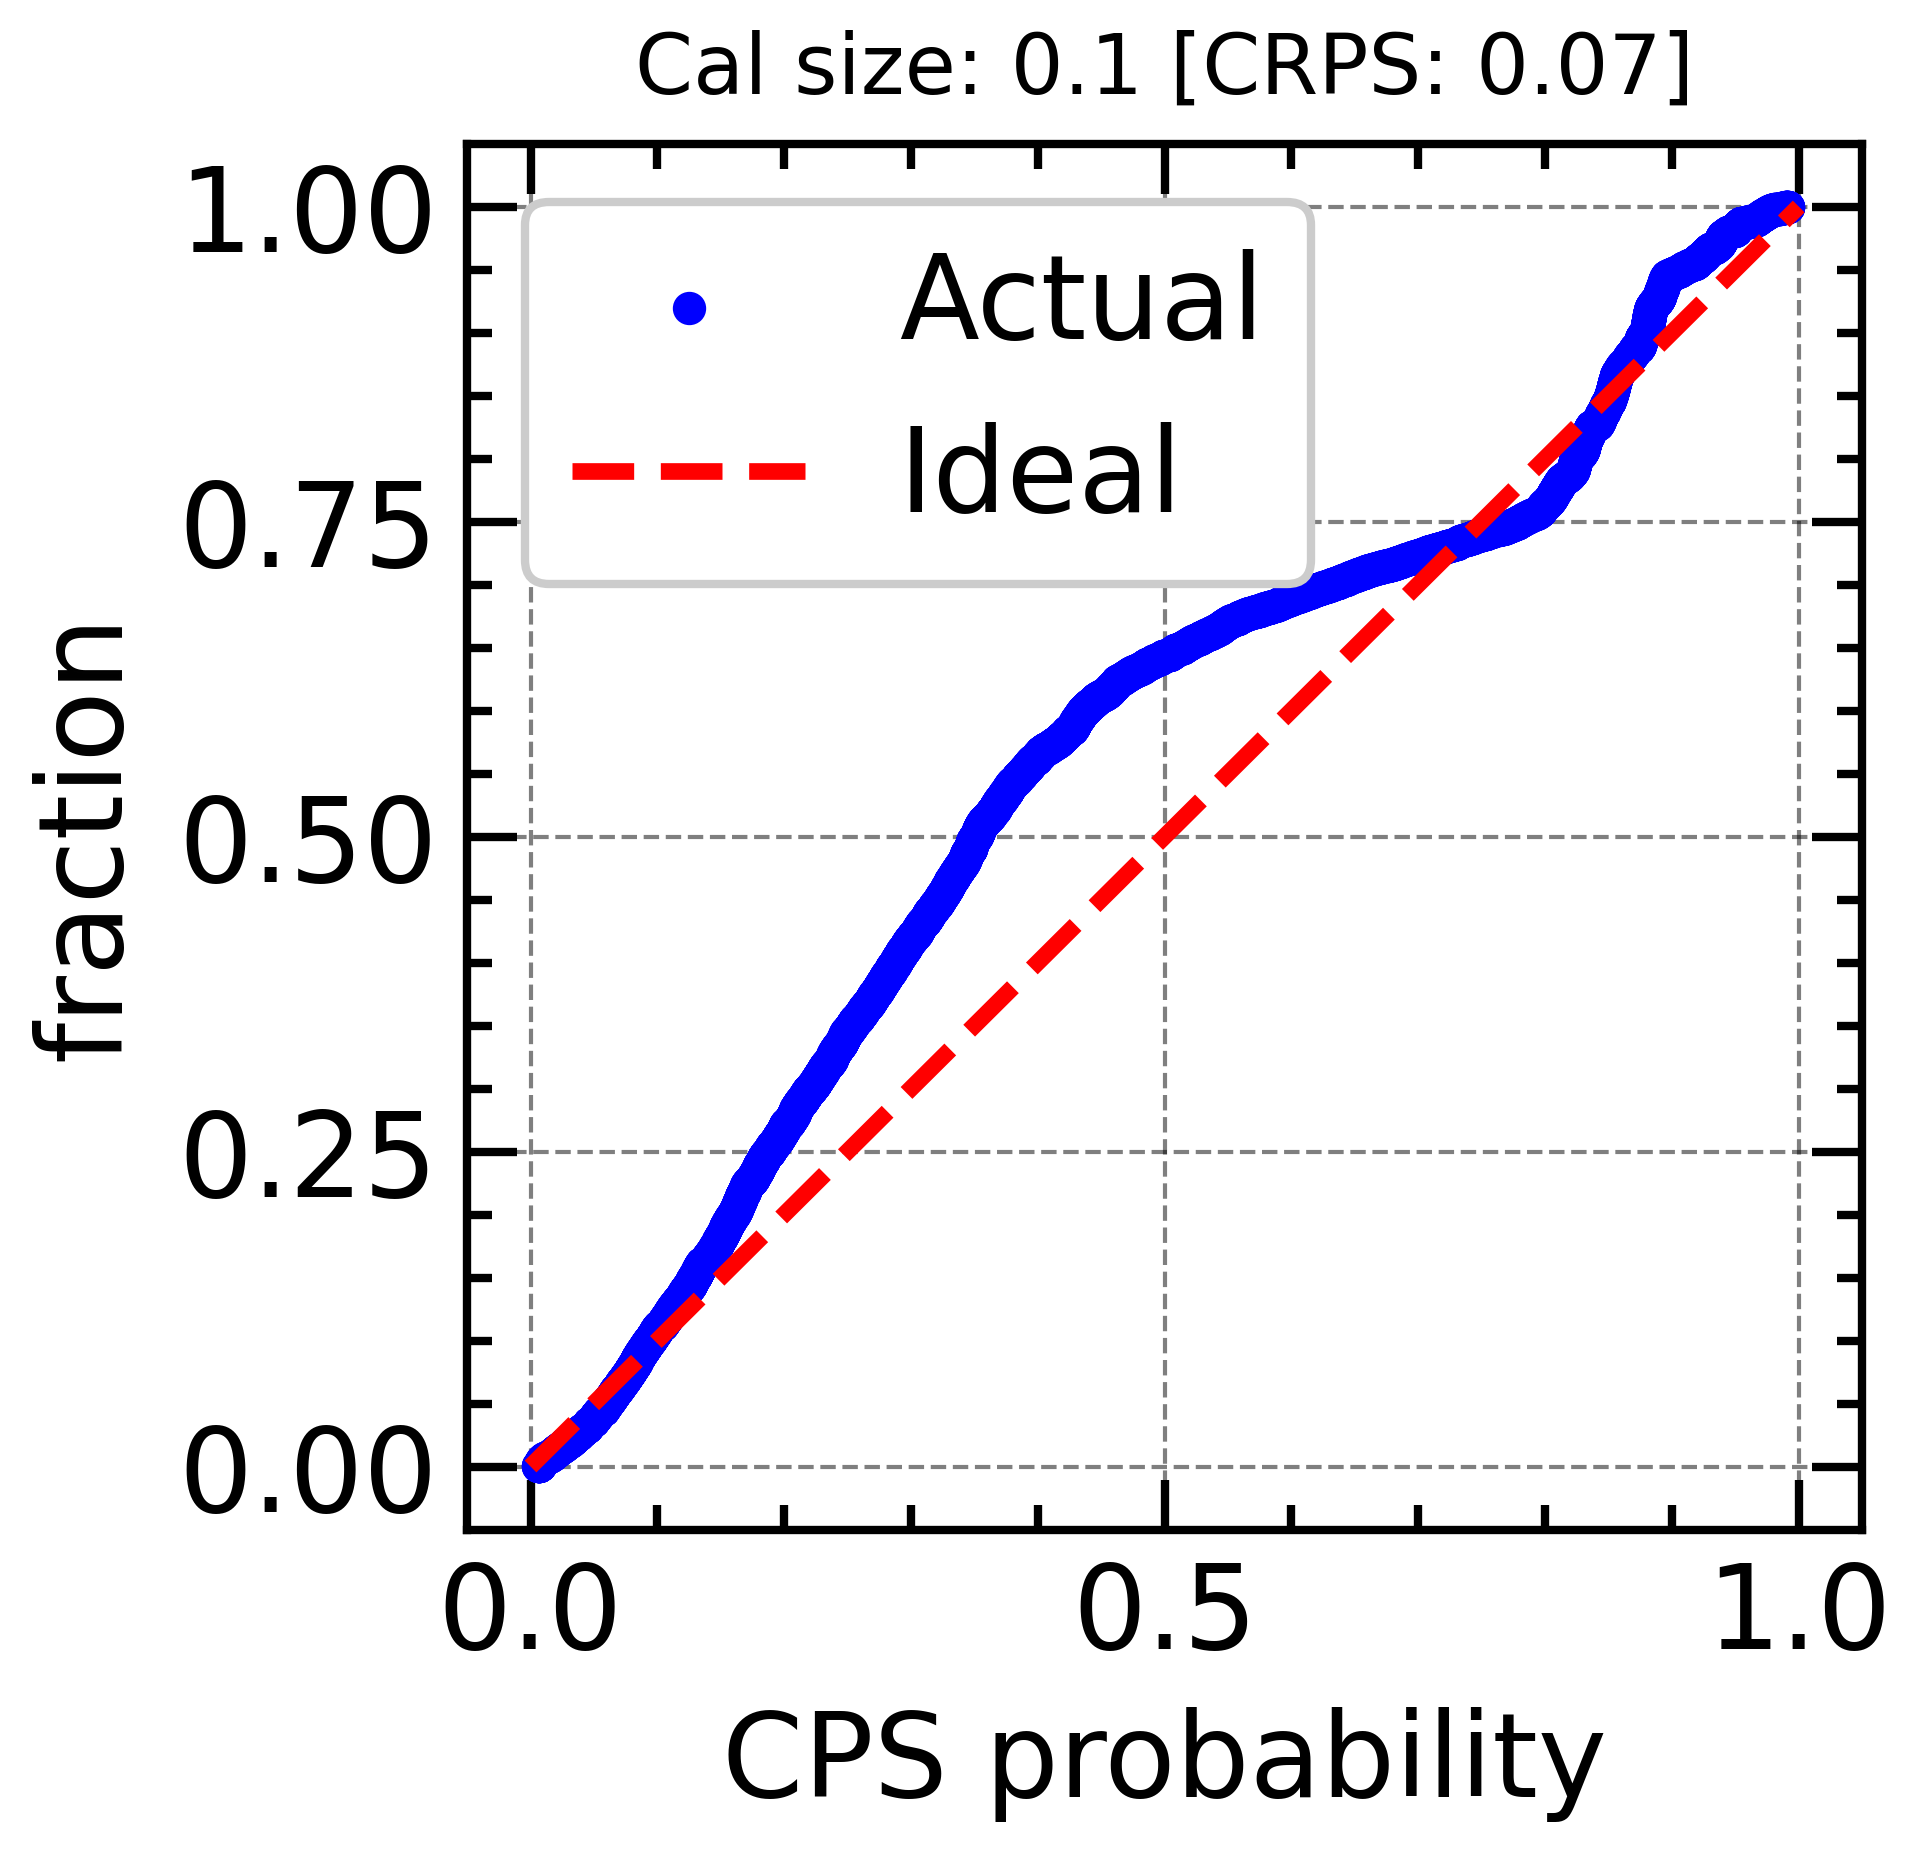

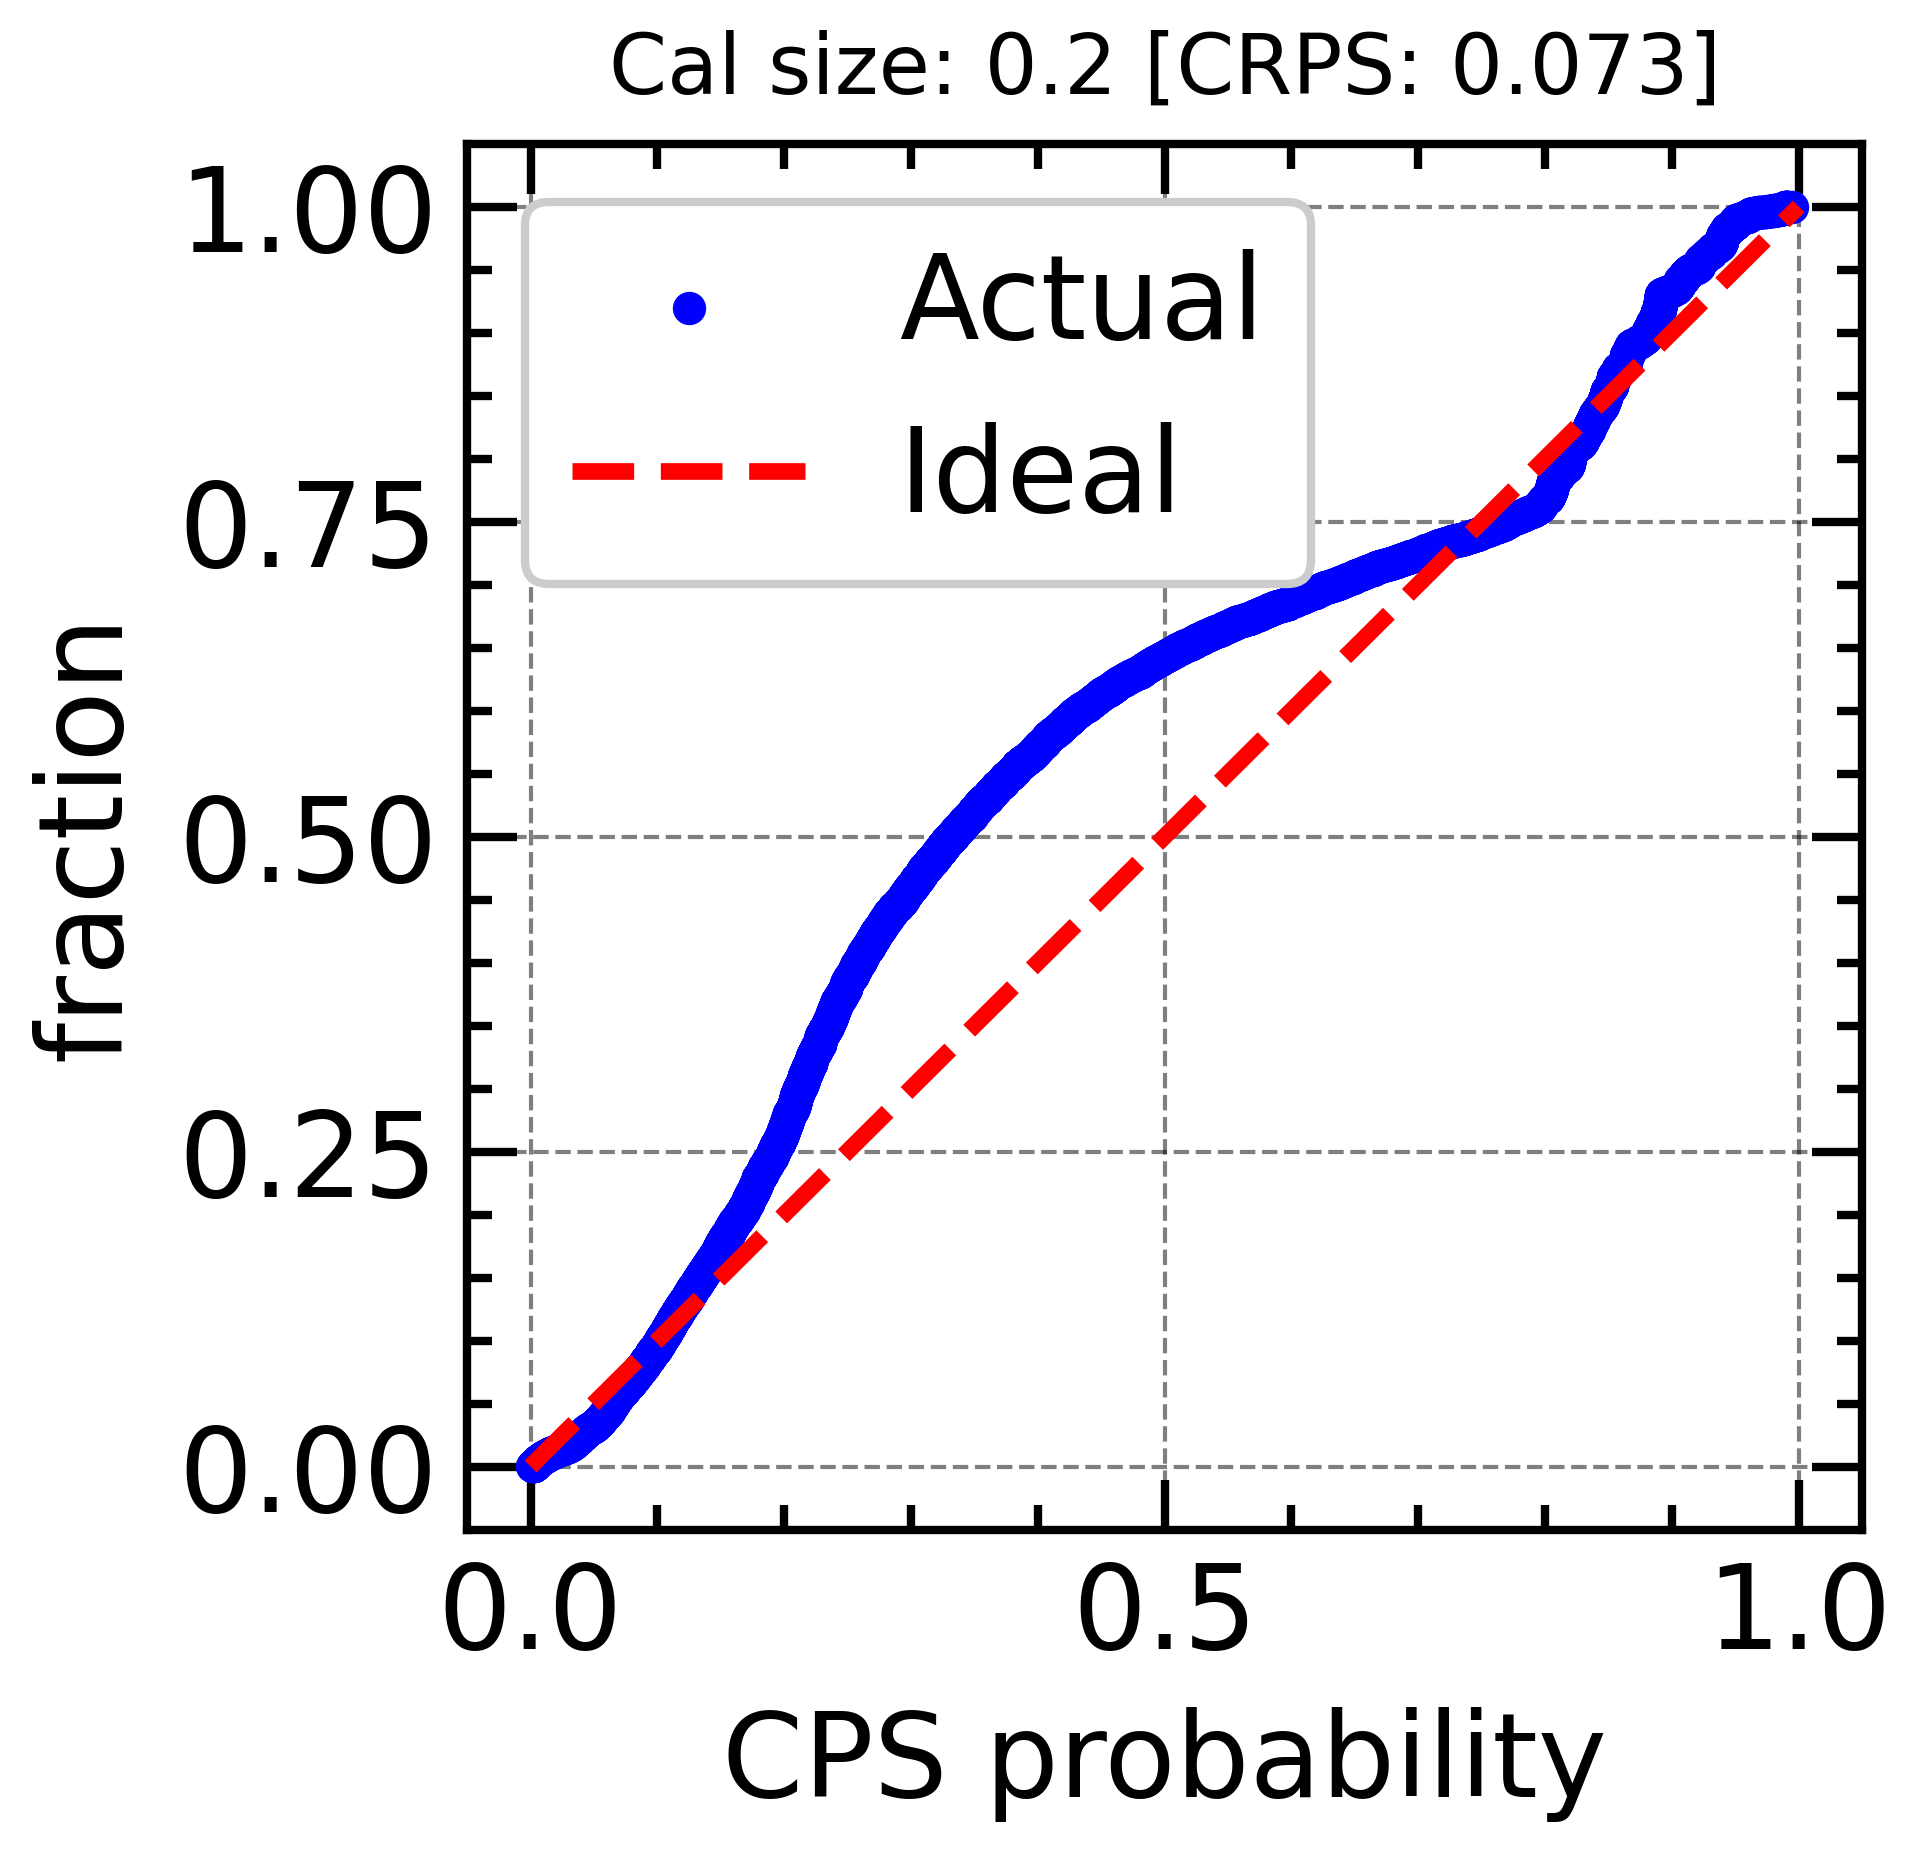

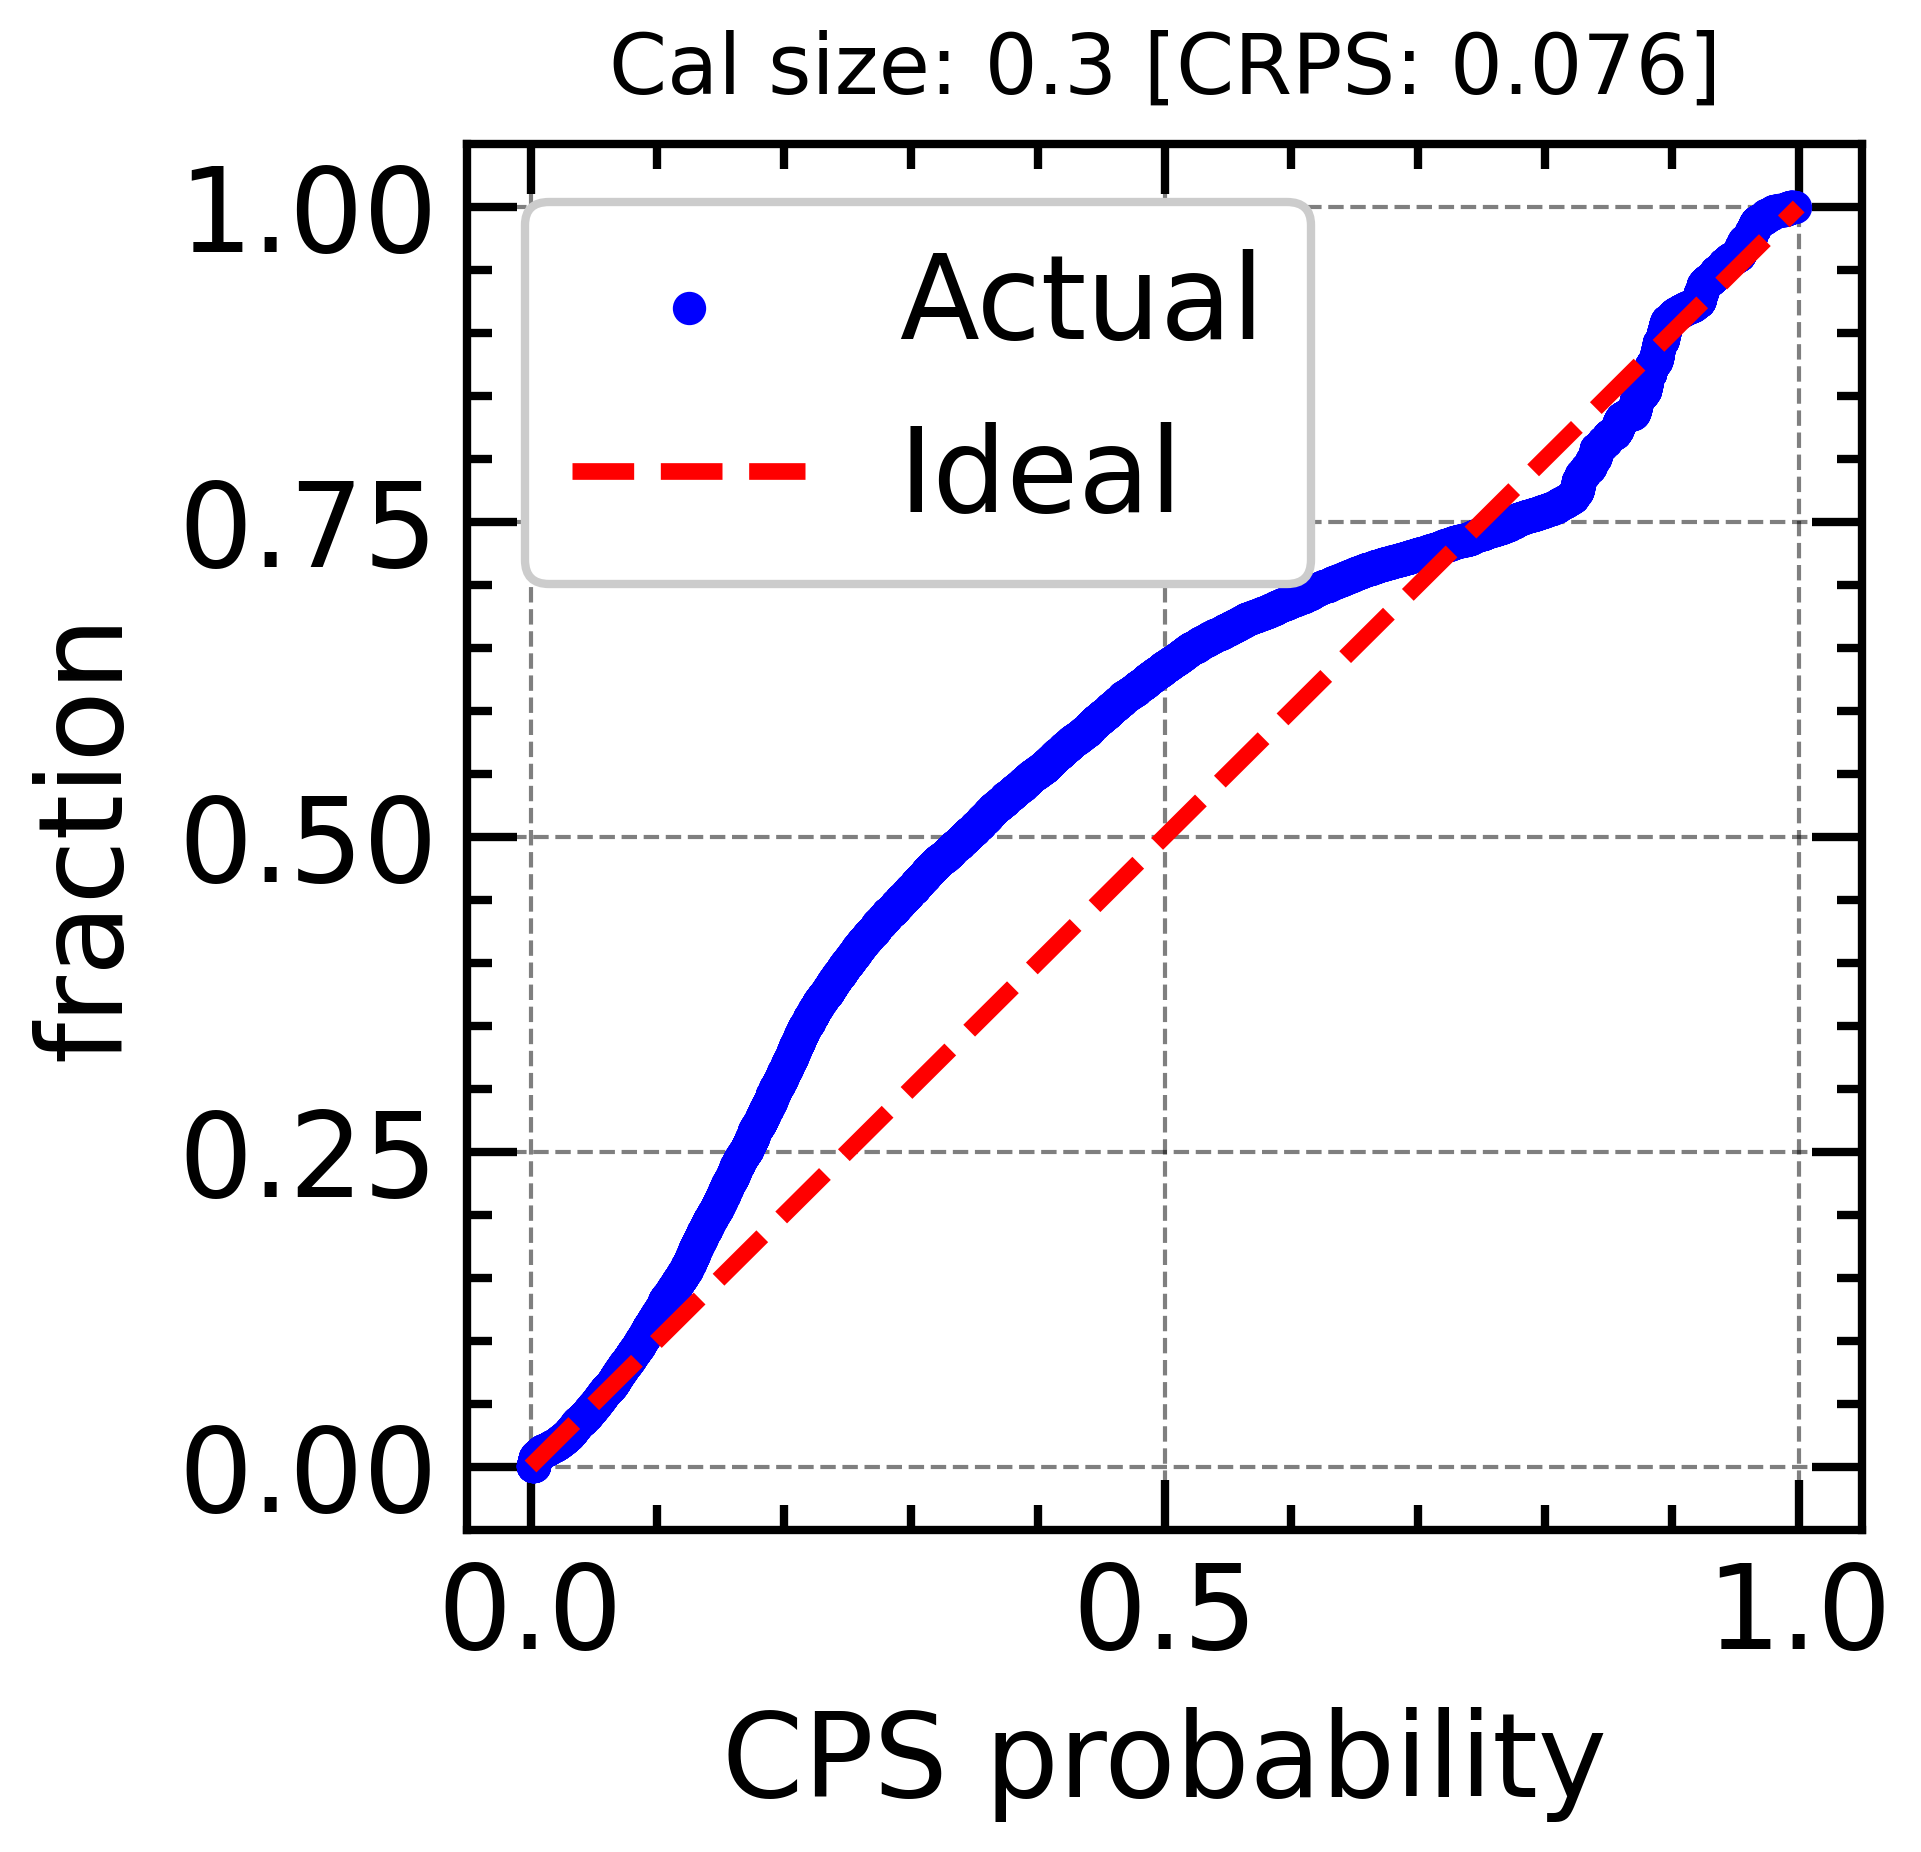

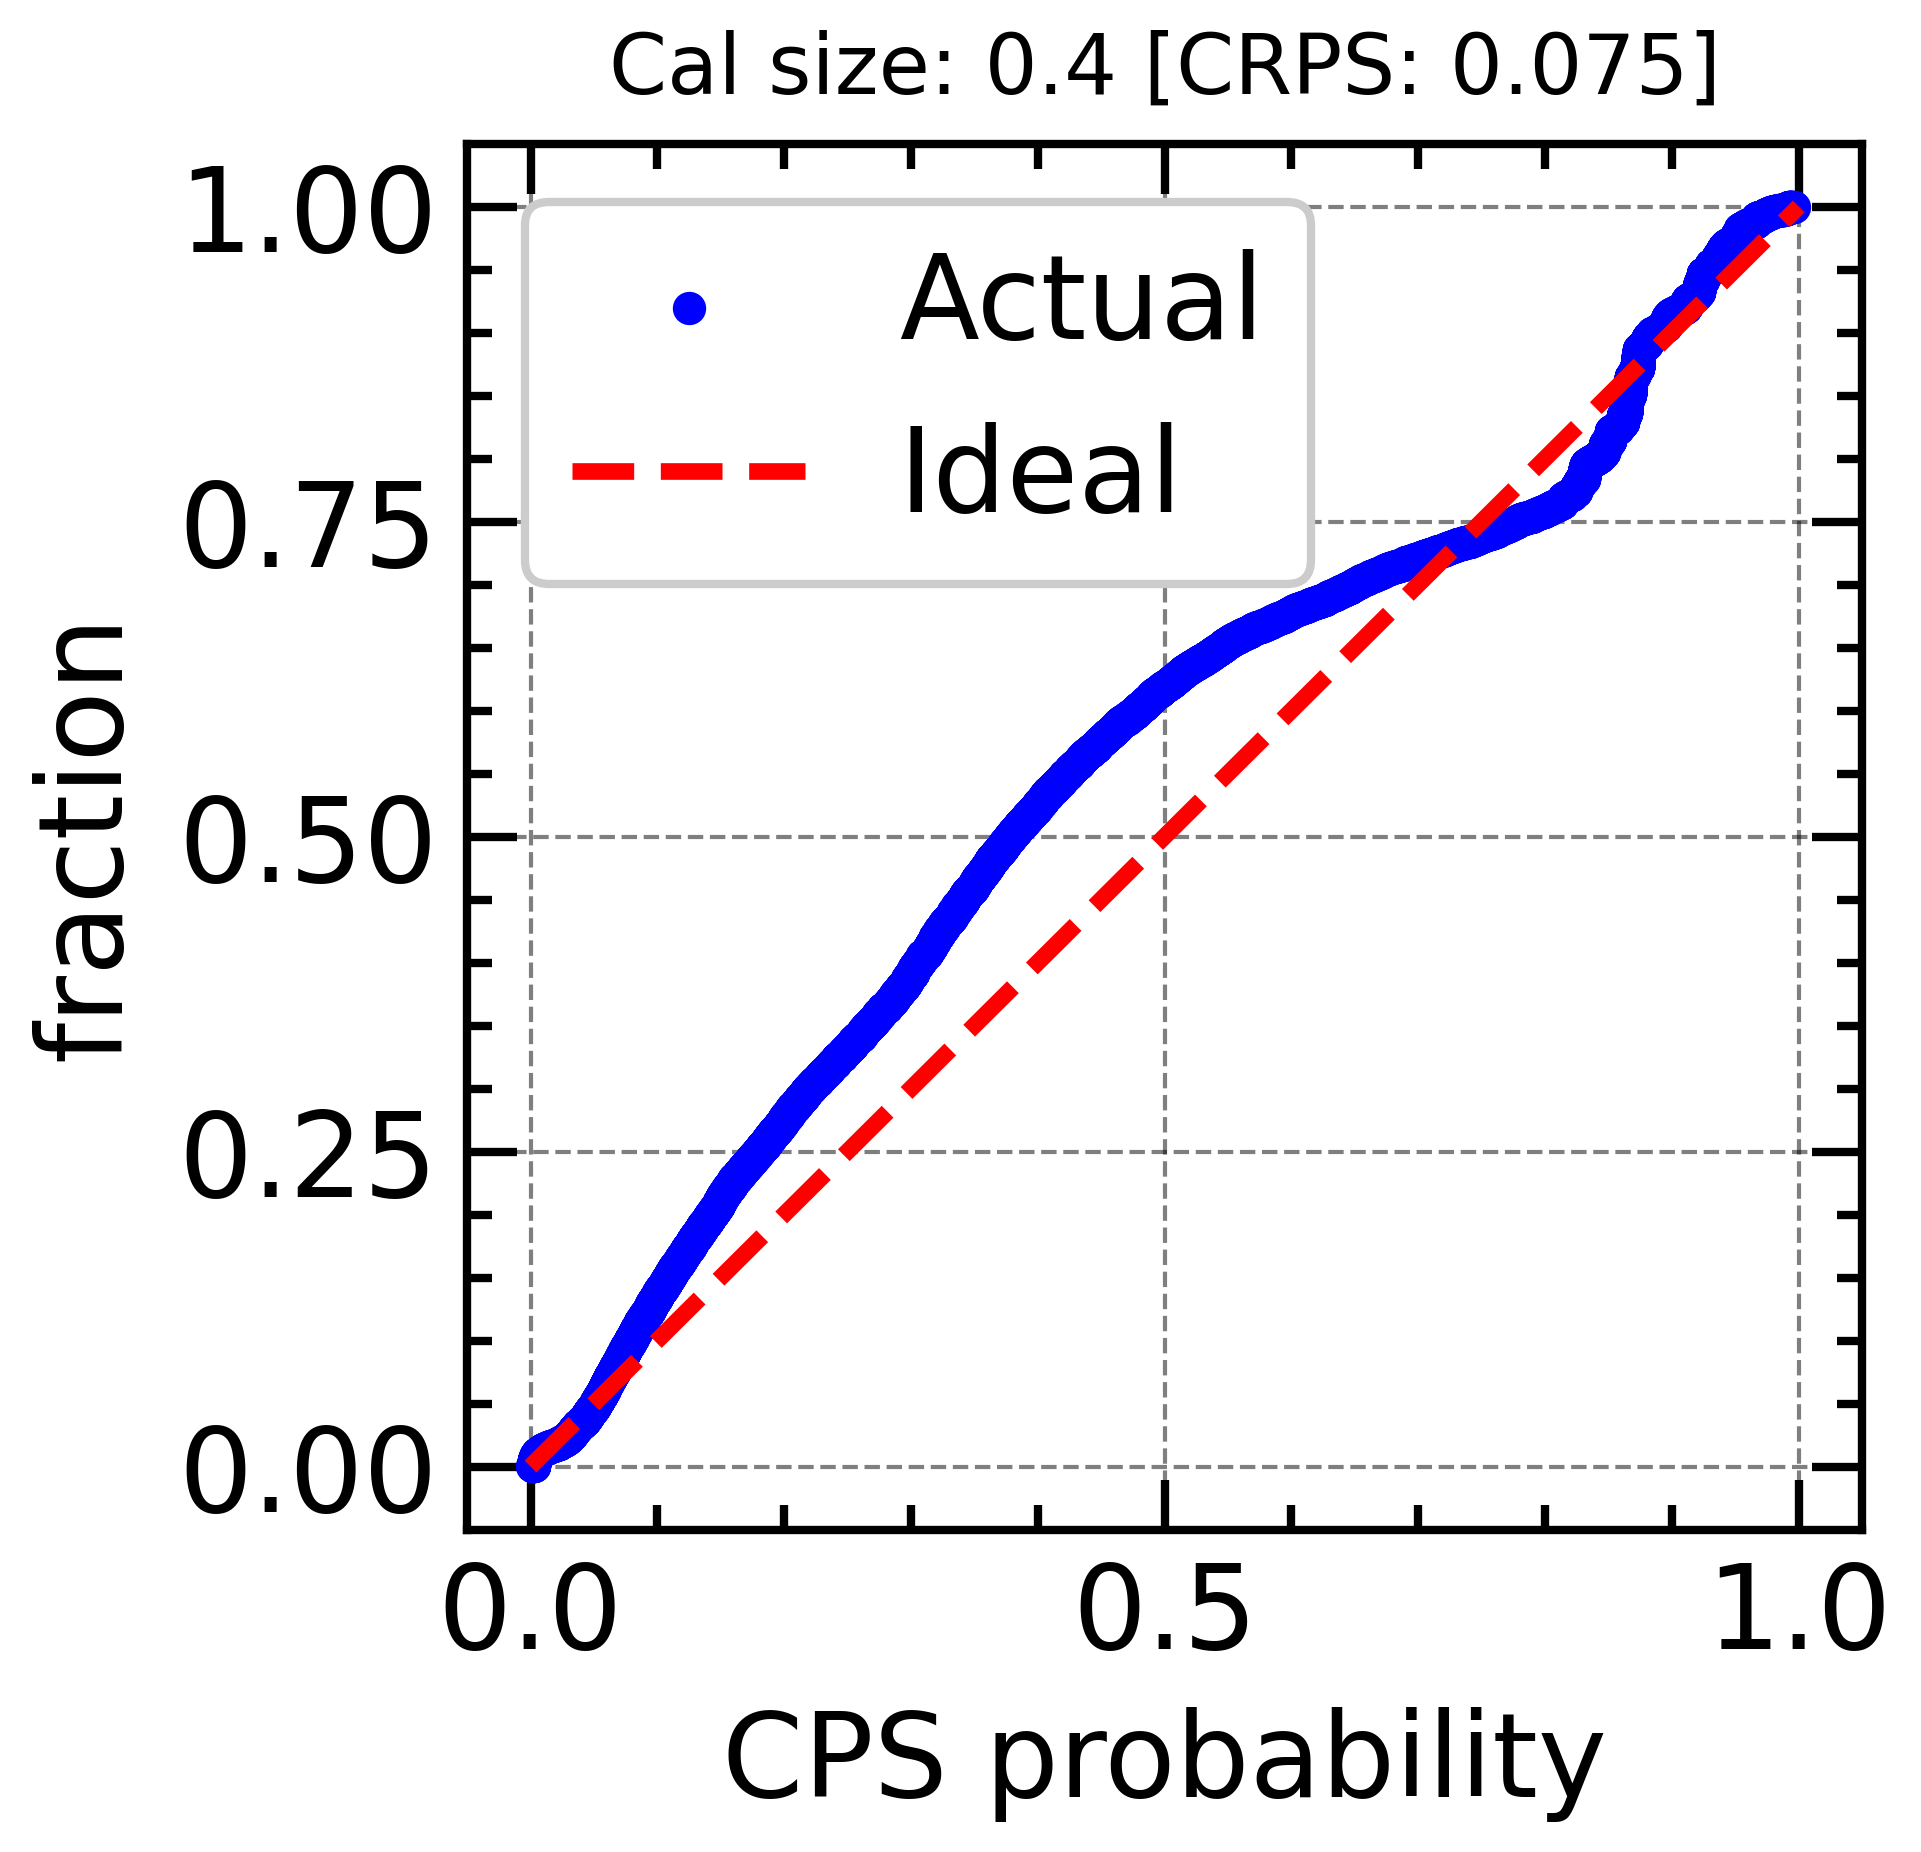

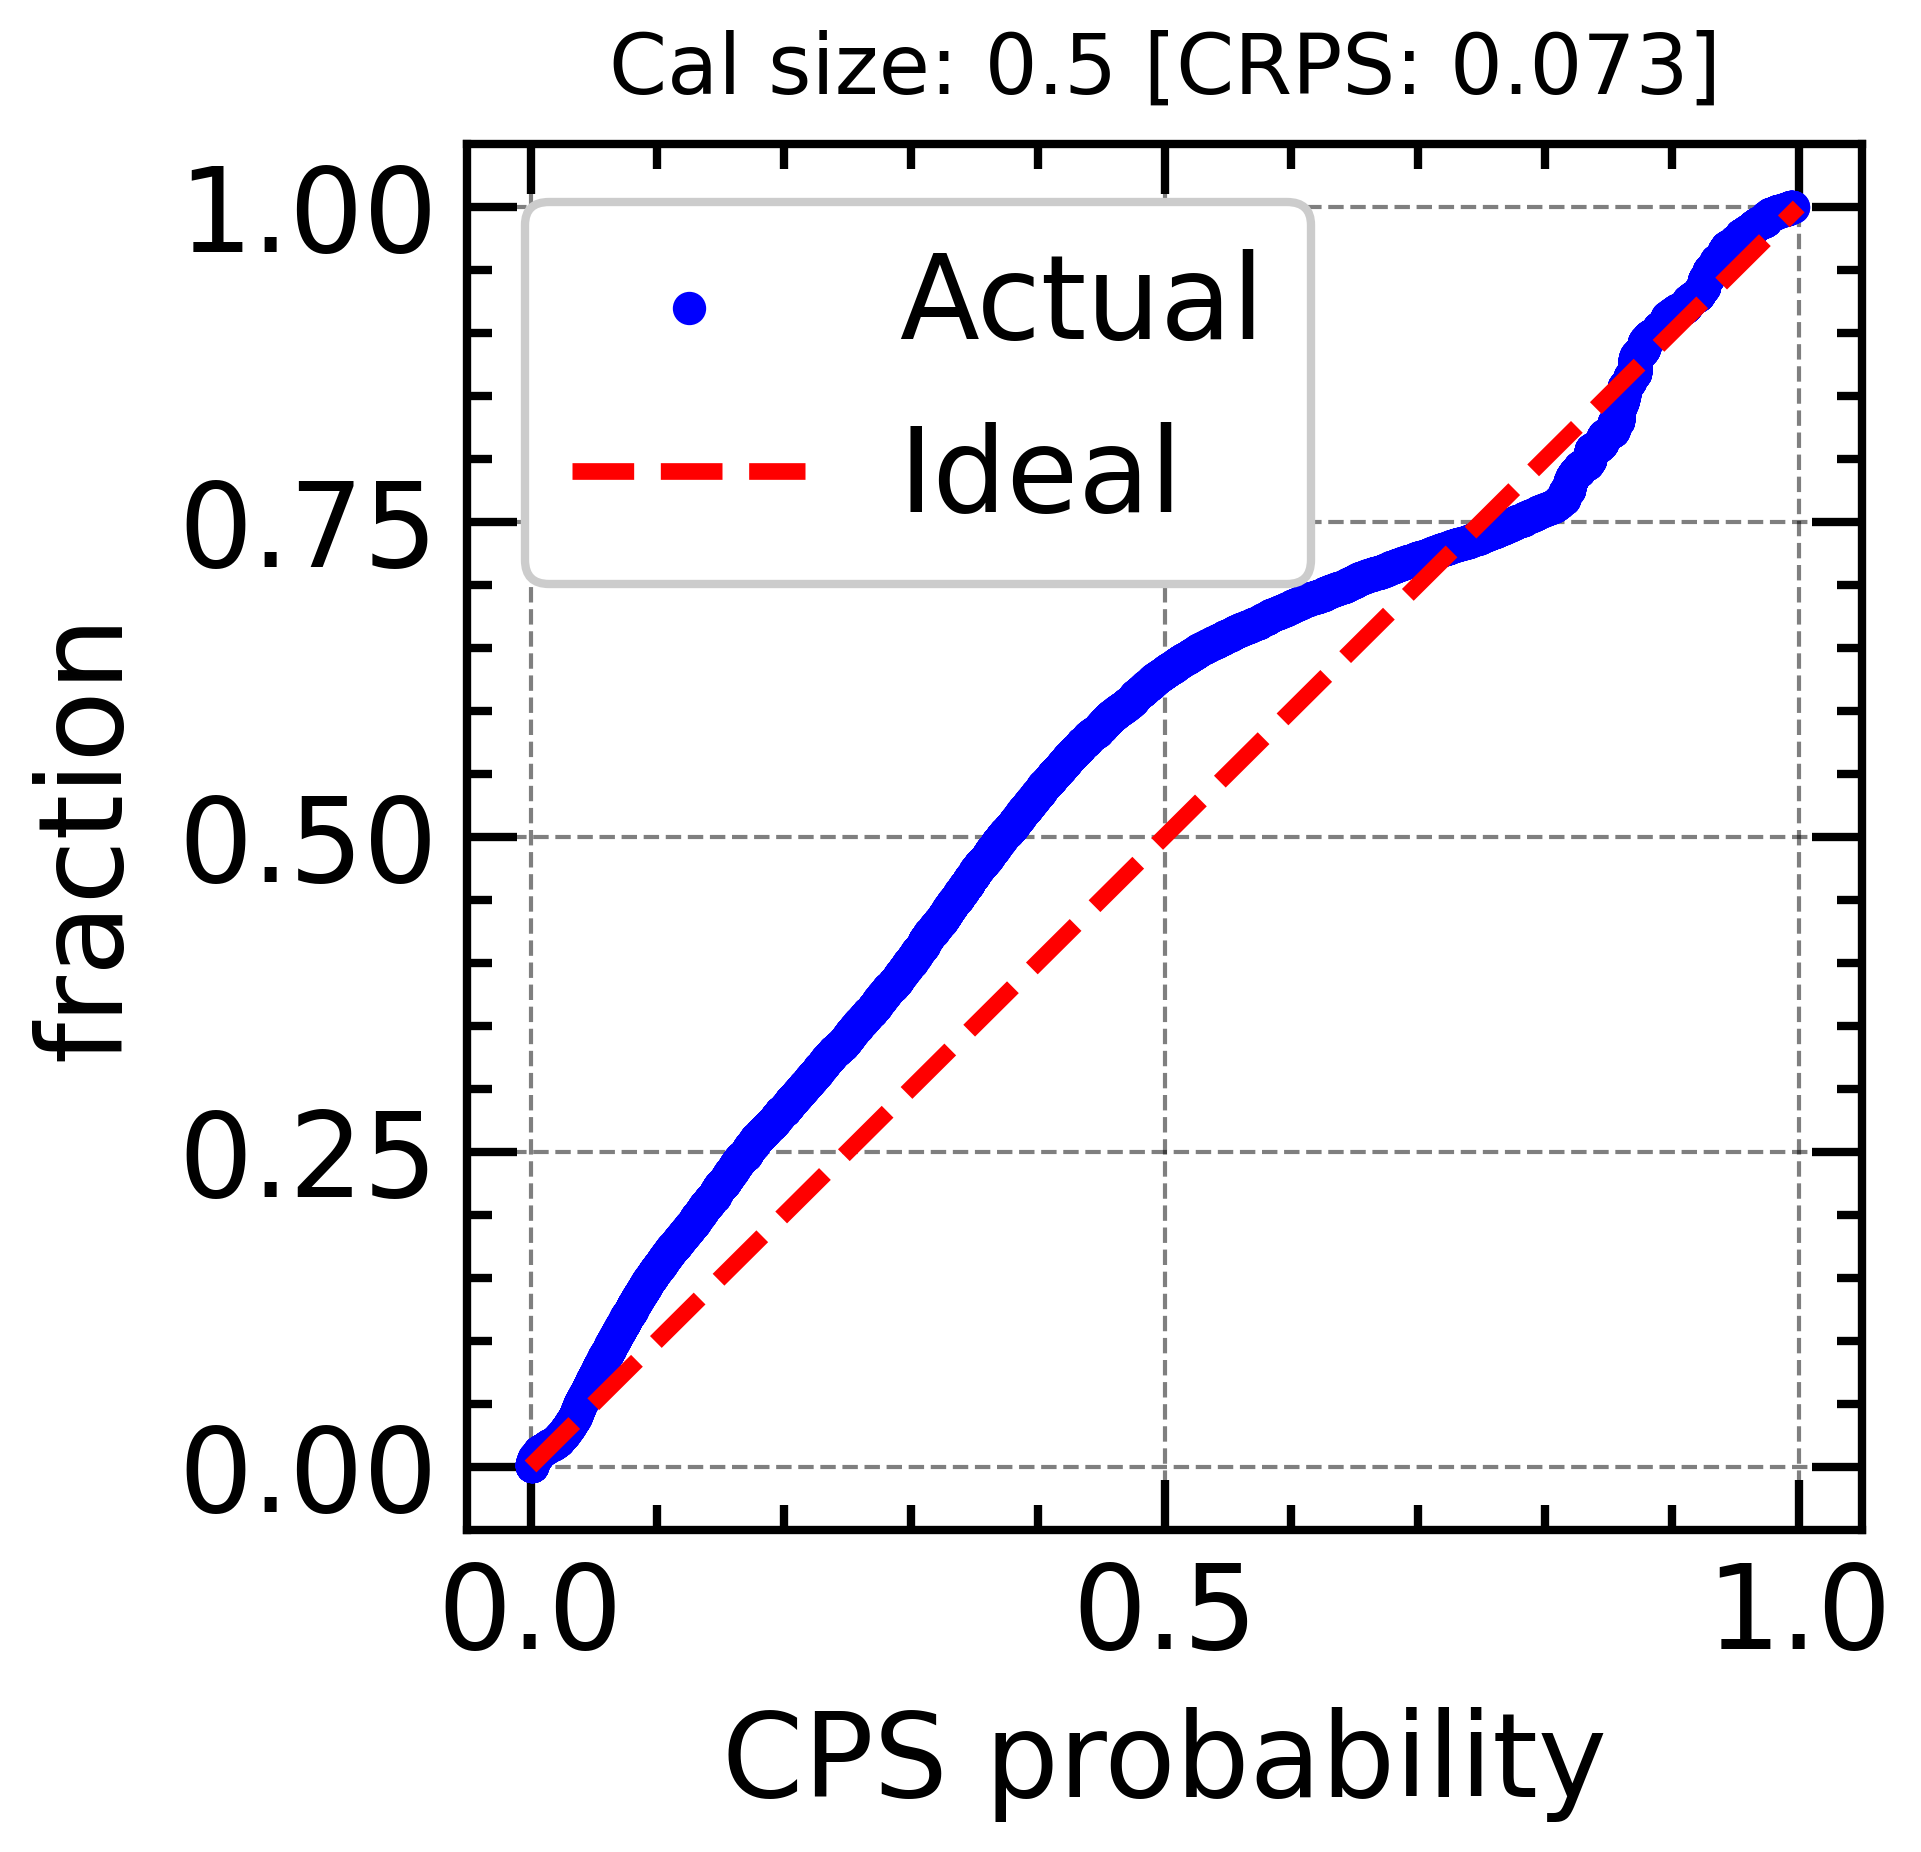

In [8]:
for key in indices:

    crps_array = np.median(np.mean(full_crps[key], axis=-1))
    pval_array = np.mean(full_pvals[key], axis=-1)

    plt.figure(figsize=(3, 3))
    plt.scatter(
        np.sort(pval_array),
        [(i + 1) / len(pval_array) for i in range(len(pval_array))],
        label="Actual",
        c="b",
        marker=".",
    )

    true = [(i + 1) / len(pval_array) for i in range(len(pval_array))]
    pred = np.sort(pval_array)
    
    plt.plot([0, 1], [0, 1], "r--", label="Ideal")
    plt.legend()
    plt.ylabel("fraction")
    plt.xlabel("CPS probability")
    plt.title(f"Cal size: {key} [CRPS: {np.round(np.mean(crps_array),3)}]")

In [9]:

train_sc = X_prop_train
cal_sc = X_cal
test_sc = X_test

pca = PCA(n_components=2)
pcs_train = pca.fit_transform(train_sc)
pcs_cal = pca.fit_transform(cal_sc)
pcs_test = pca.transform(test_sc)

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

%time embedding_train = tsne.fit(train_sc)
%time embedding_cal = tsne.fit(cal_sc)
%time embedding_test = embedding_train.transform(test_sc)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 7.76 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.29 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=12.00, lr=1666.67 for 250 iterations...
Iteration   50, KL divergence 3.8785, 50 iterations in 3.2961 sec
Iteration  100, KL divergence 3.4830, 50 iterations in 3.2340 sec
Iteration  150, KL divergence 3.2254, 50 iterations in 4.2183 sec
Iteration  200, KL divergence 3.0882, 50 iterations in 3.3908 sec
Iteration  250, KL divergence 2.9996, 50 iterations in 3.3232 sec
   --> Time elapsed: 17.46 seconds
===> Running optimization with exaggeration=

In [11]:
percentile_thresh = 75
thresh = 0.33
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

metric = full_pvals[0.1]
uncert = np.mean(metric * (1 - metric), axis=-1)
confidence = np.mean(metric, axis=-1)

# Get groups and mainly well-estimated groups
oe_group = np.where(
    (confidence <= conf_thresh_low)
    & (uncert <= np.percentile(uncert, percentile_thresh))
)[0]
ue_group = np.where(
    (confidence >= conf_thresh_high)
    & (uncert <= np.percentile(uncert, percentile_thresh))
)[0]

combined_group = np.concatenate((oe_group, ue_group))

we_group = []
for id in range(len(confidence)):
    if id not in combined_group:
        we_group.append(id)

we_group = np.array(we_group)

embedding_train_ue = pcs_train[ue_group, :]
embedding_train_we = pcs_train[we_group, :]
embedding_train_oe = pcs_train[oe_group, :]
embedding_cal_orig = pcs_cal
embedding_test_orig = pcs_test

In [13]:


plot_dfs = []
eval_groups = ["Under", "Well", "Over", "Cal", "Test"]

orig_dfs = []

for subset in eval_groups:

    minmaxscale = MinMaxScaler()
    scaledX = minmaxscale.fit_transform(X_prop_train)

    logging.info(f"Analyzing {subset}")

    if subset == "Under":
        embed = embedding_train_ue
        group = ue_group
        orig_dfs.append(X_prop_train[ue_group, :])
    if subset == "Well":
        embed = embedding_train_we
        group = we_group
        orig_dfs.append(X_prop_train[we_group, :])
    if subset == "Over":
        embed = embedding_train_oe
        group = oe_group
        orig_dfs.append(X_prop_train[oe_group, :])
    if subset == "Cal":
        embed = embedding_cal_orig
        group = np.array(range(len(y_cal)))
        scaledX = minmaxscale.transform(X_cal)
        orig_dfs.append(X_cal)
    if subset == "Test":
        embed = embedding_test_orig
        group = np.array(range(len(y_test)))
        scaledX = minmaxscale.transform(X_test)
        orig_dfs.append(X_test)

    sil_score = []

    if embed.shape[0] - 1 <= 10:
        n = 9
    else:
        n = 10
    for i in range(n):
        gm = GaussianMixture(n_components=i + 2, random_state=0).fit(embed)

        clusters = gm.predict(embed)
        sil_score.append(metrics.silhouette_score(
            embed, clusters, metric="euclidean"))

    best = np.argsort(sil_score)[1] + 1
    best = 1  # for visualizing purposes - can be changed to min sil_score idx too

    gm = GaussianMixture(n_components=best, random_state=0).fit(embed)

    clusters = gm.predict(embed)

    unique_labels = np.unique(clusters)

    xdata = X_prop_train

    mean_list = []
    cluster_dict = {}
    for label in unique_labels:
        samples = np.where(clusters == unique_labels[label])[0]

        minmax_vals = scaledX[group[samples], :]
        mean_vals = np.mean(minmax_vals, axis=0)
        mean_list.append(mean_vals)
        mean_vals = pd.Series(mean_vals, index=cols)
        n_samples = len(y_prop_train[group[samples]])

        if subset == "Test":
            n_samples = len(y_test[group[samples]])
            mean_label = np.mean(y_test[group[samples]])
        elif subset == "Cal":
            n_samples = len(y_cal[group[samples]])
            mean_label = np.mean(y_cal[group[samples]])

        else:
            n_samples = len(y_prop_train[group[samples]])
            mean_label = np.mean(y_prop_train[group[samples]])

        updated_series = pd.concat(
            [mean_vals, pd.Series([mean_label], index=["label"])]
        )
        cluster_dict[label] = updated_series

    cluster_df = pd.DataFrame(cluster_dict)

    groups = []
    for i in range(cluster_df.shape[1]):
        groups.append(i)
    group_dict = {"group": groups}

    for idx in list(cluster_df.index):
        group_dict[idx] = cluster_df.loc[[idx]].values[0]

    # Set data
    group_df = pd.DataFrame(group_dict)
    plot_dfs.append(group_df)

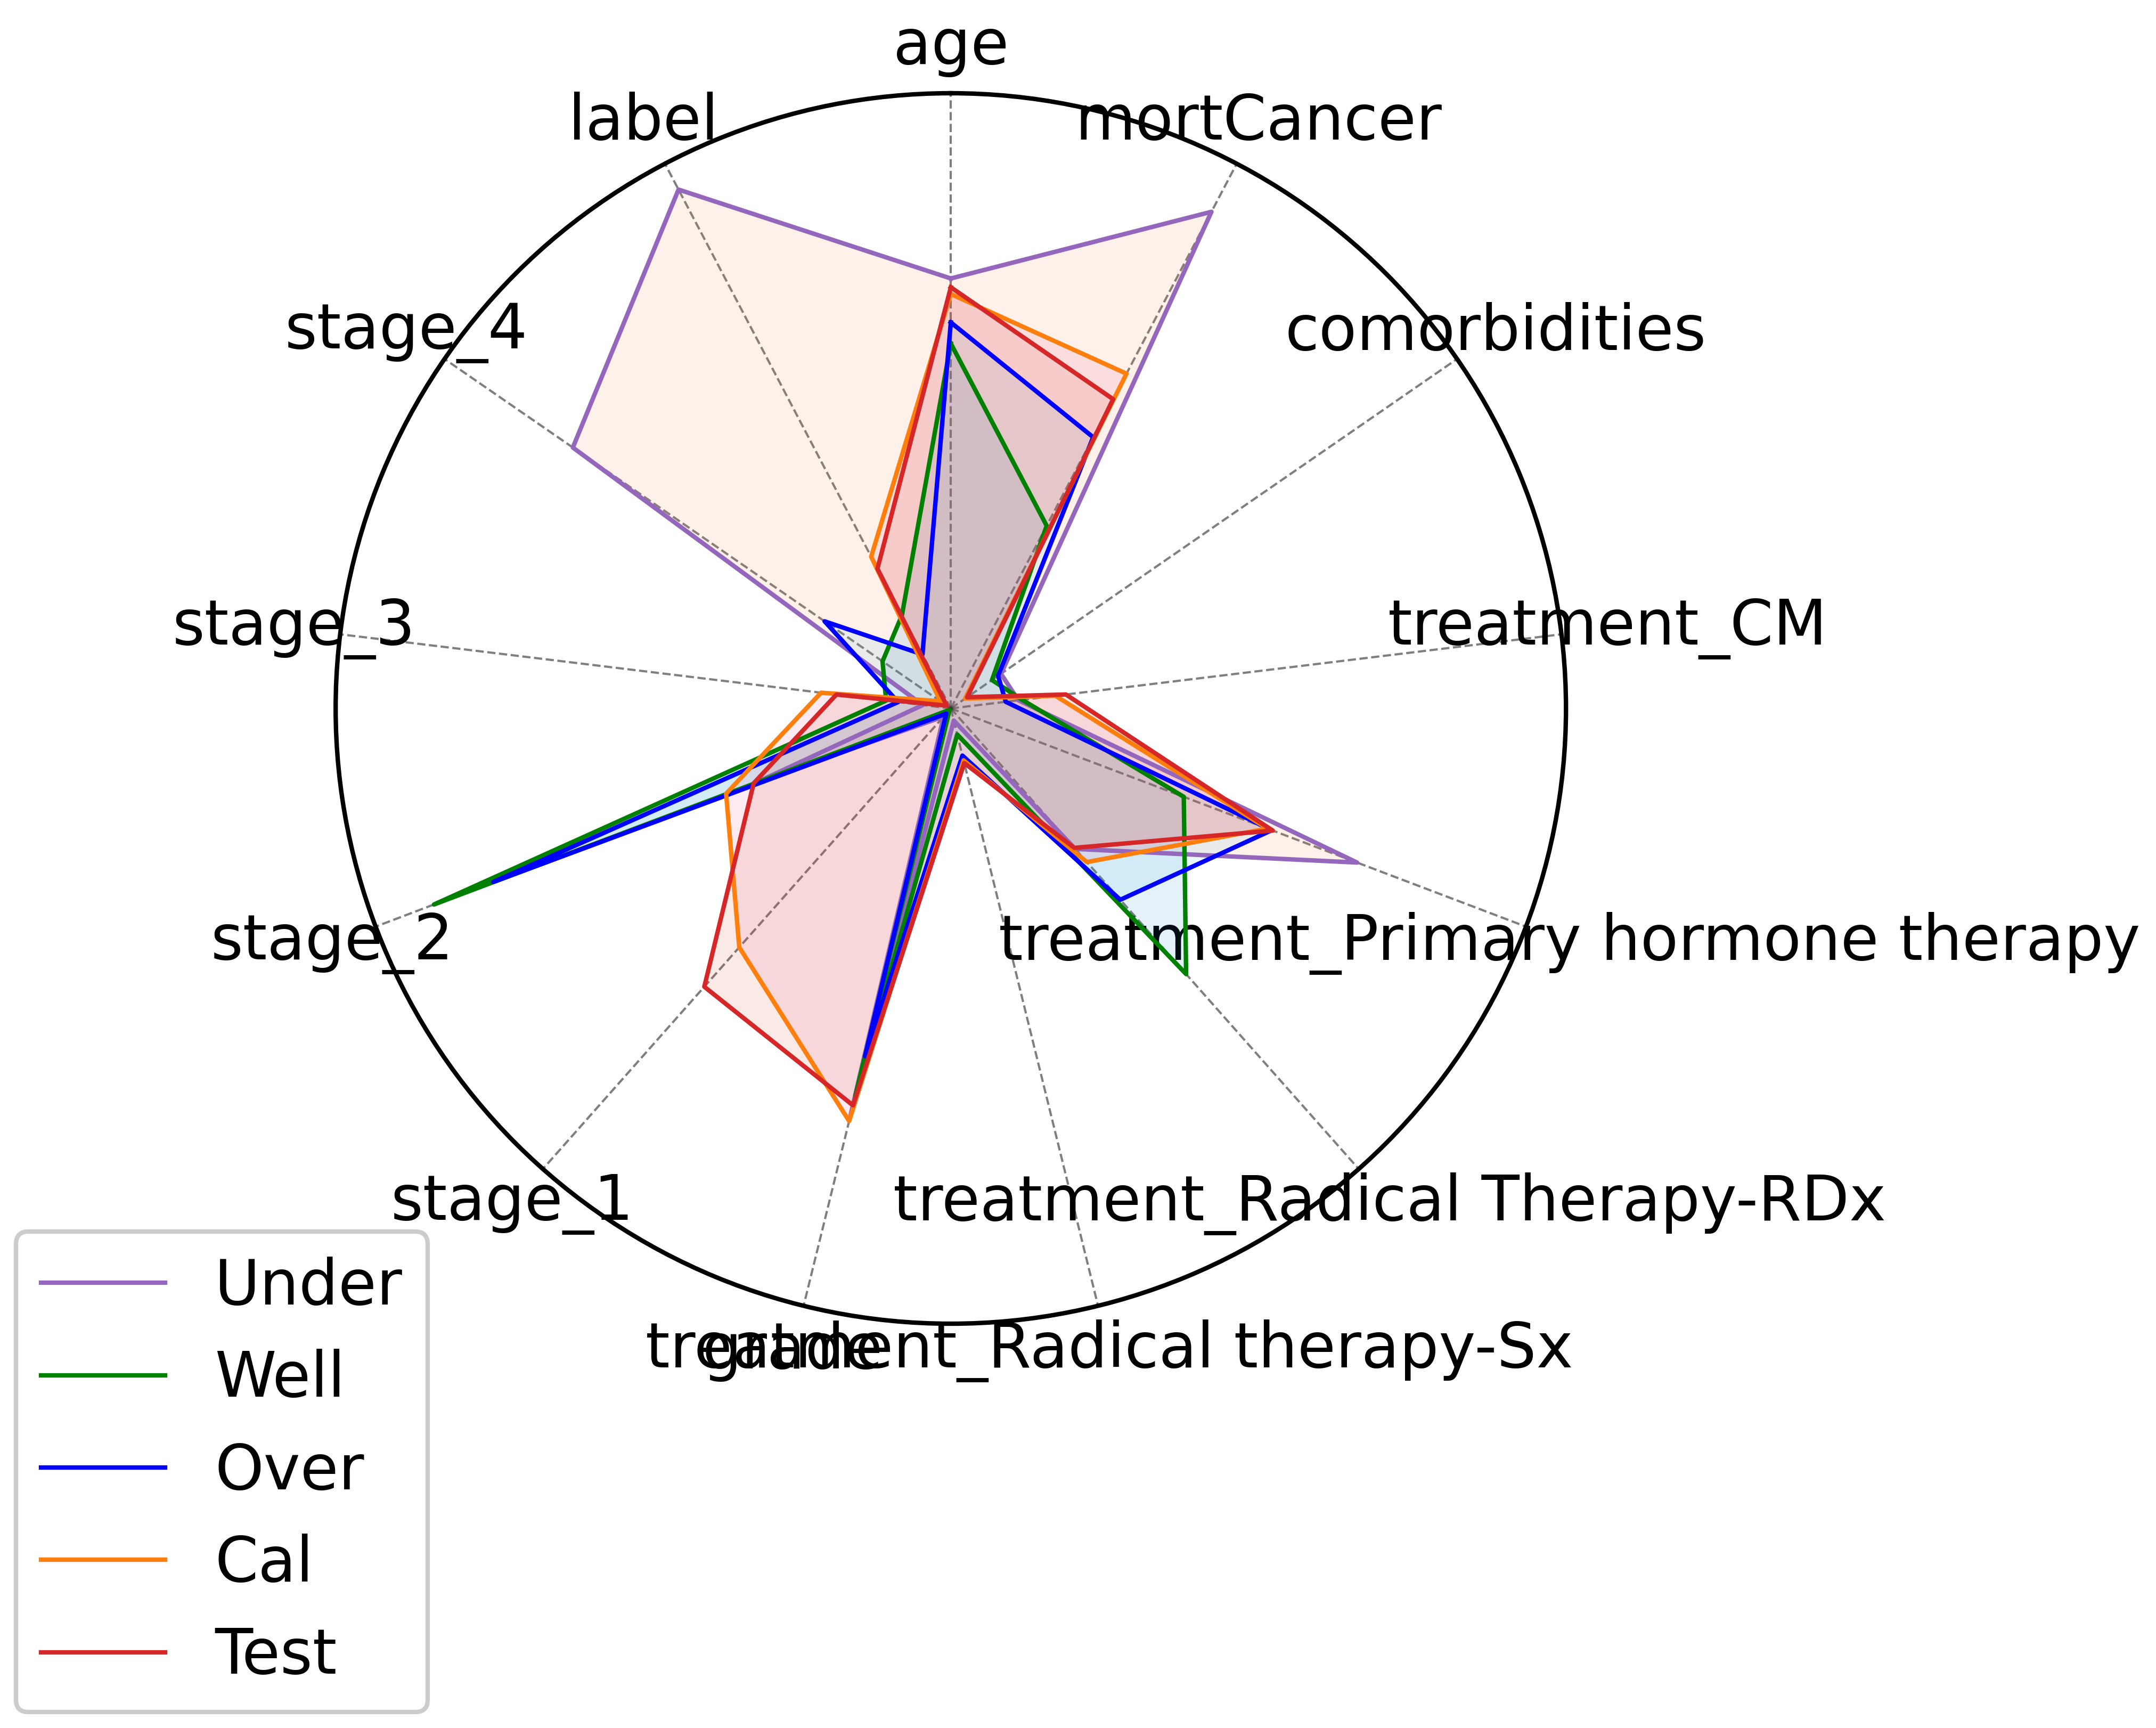

In [15]:
from math import pi

group_df = pd.concat(plot_dfs).reset_index()
group_df = group_df.drop(columns=["group", "index"])
######################################################################

# RADIAL DIAGRAM

######################################################################
# number of variables
categories = list(group_df)  # [1:]
N = len(categories)

colors = ["tab:purple", "g", "b", "tab:orange", "tab:red"]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(5, 5))
# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10, 20, 30], ["10", "20", "30"], color="grey", size=7)
# plt.ylim(0, 1)

for i in range(len(group_df)):
    values = group_df.loc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=1,
        linestyle="solid",
        label=eval_groups[i],
        color=colors[i],
    )
    ax.fill(angles, values, alpha=0.1)


# Add legend
plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
# plt.title(subset)
# plt.savefig(f"{dataset}_{subset}.svg", format="svg", dpi=1200)
# Show the graph
plt.show()